In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from prettytable import PrettyTable
import pickle
from functools import partial
import numpy as np
from glob import glob
from collections.abc import Iterable
from collections import defaultdict

from utils import get_dfs, plot_metric

# Utils

In [134]:
def plot_gain_dist_by_episode(name, title=None, train=False):
  folder = 'train' if train else 'eval'
  n_envs = len(glob(f'../runs/{name}/{folder}-*'))
  max_nb_episodes = max([len(glob(f'../runs/{name}/{folder}-*{i}/*')) for i in range(n_envs)])

  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  def extract_label(filename):
    res = re.search(r'(\d)/(\d)/progress.csv', filename)
    return f'Env {res.group(1)}, Episode {res.group(2)}'
  
  def metric(f, df):
    return np.arange(len(df)), df['obs/cum_obs/vmc/0'].to_numpy()*.1

  for env_id in range(n_envs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Env {env_id}')
    plot_metric(
      [f'{name}/{folder}-*{env_id}/{i}' for i in range(max_nb_episodes)],
      metric=metric,
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True)
  for i in range(max_nb_episodes):
    axs[1, 3].plot([], [], label=f'Episode {i}')

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=4)

In [4]:
def plot_training_evolution(name, wind_dirs=[45, 90, 135, 180, 225, 270, 315], model_folder=None, eval=True, show_reward=False):
  def extract_step(filename):
    res = re.search(rf'{name}-(\d+)', filename)
    return int(res.group(1))

  def extract_env(filename):
    res = re.search(r'-(\d+)/0/', filename)
    return int(res.group(1))

  if model_folder is None:
    model_folder = name

  files = glob(f'../runs/{name}-*')
  files = sorted(files, key=extract_step)
  if len(files) == 0:
    files = glob(f'../runs/{name}')

  print(f'Found {len(files)} files')

  folder = 'eval' if eval else 'train'

  by_wind = defaultdict(list)
  by_step = defaultdict(list)
  steps = set()
  for i, file in enumerate(files):
    dfs = get_dfs(f'{file}/{folder}-*/0/')
    for key, df in dfs.items():
      wind_idx = extract_env(key)
      wind_dir = wind_dirs[wind_idx]
      step = extract_step(key)
      steps.add(step)
      score = df[f'obs/cum_obs/vmc/0'].iloc[-1]*.1
      if show_reward:
        cum_reward = df[f'reward'].sum()
      else:
        cum_reward = 0
      by_wind[wind_dir].append((score, cum_reward))
      by_step[step].append((score, cum_reward))

  args = pickle.load(open(f'../runs/{model_folder}/model_args.pkl', 'rb'))
  print('Hparams:')
  pt = PrettyTable()
  pt.field_names = ['Name', 'Value']
  for k, v in args.__dict__.items():
    if k in ['name', 'env_name', 'seed', 'reward_kwargs', 'policy_kwargs']:
      continue
    pt.add_row([k, v])
  print(pt)
  print()

  print('Mean scores by step:')
  pt = PrettyTable()
  pt.field_names = ['Step', 'Mean score', 'Mean cum. reward']
  for step, data in by_step.items():
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    pt.add_row([f'{round(step/1e3):d}K', np.mean(scores), np.mean(cum_reward)])
  print(pt)
  print()

  steps = list(sorted(steps))

  if show_reward:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
  else:
    fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    axs = [axs]
  for wind_dir in wind_dirs:
    data = by_wind[wind_dir]
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    axs[0].plot(steps, scores, label=f'{wind_dir}°')
    if show_reward:
      axs[1].plot(steps, cum_reward)
  axs[0].set_xlabel('Training step')
  if show_reward:
    axs[1].set_xlabel('Training step')
  axs[0].set_ylabel('Cum. dist.')
  axs[0].set_ylabel('Cum. reward')
  fig.suptitle(name)
  # right legend
  fig.legend(bbox_to_anchor=(1.05, .5), loc='center left')

In [ ]:
# def extract_step(filename):
#   res = re.search(r'(\d+)$', filename)
#   return int(res.group(1))

# files = glob('../runs/08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1*')
# files = sorted(files, key=extract_step)

# plot_gain_dist_by_episode(
#   names=[f'{f}/eval-*' for f in files],
#   labels=[f'{round(extract_step(f)/1e3)}K'  for f in files]
# )

# Reflexions

## VMC > gain_dist (maybe)
VMC seems better than gain_dist because it is more stable

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/gain_dist/0'].plot(label='gain_dist')
(df['obs/vmc/0']*.1).plot(label='vmc')
plt.legend()

## Remove noisy sensors

- **TAE -> heading error**: TAE is really noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/tae/0'].plot(label='tae')
plt.legend()

## $\lvert \dot\theta_{rudder} \rvert \leq 6$

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='dt_theta_rudder')
plt.legend()

# $\lvert VMC \rvert \lessapprox .4$

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-1/0')
df = dfs.popitem()[1]
df['obs/vmc/0'].plot()

In [ ]:
dfs = get_dfs('08-30-B1-69972/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/cum_obs/g']

# Eval 1M steps with best hyperparams
- **Result:** degredation of performance
- **Hypothesis:** the observation was too big and possibly noisy

In [ ]:
plot_training_evolution('08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1', model_folder='08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1')

# Testing with smaller observation space (basic_2d_obs_v4) & trying with different episode duration

- **Result:** Full episode duration is better. At the end the training "crashed" because is learn to take good direction to maximize the velocity but did not learn yet to be safe about the corridor. Moreover, I find out that the observation/reward was noisy.
- **Hypothesis:** Need larger training time and stable observation/reward

## Episode duration = **200s**

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

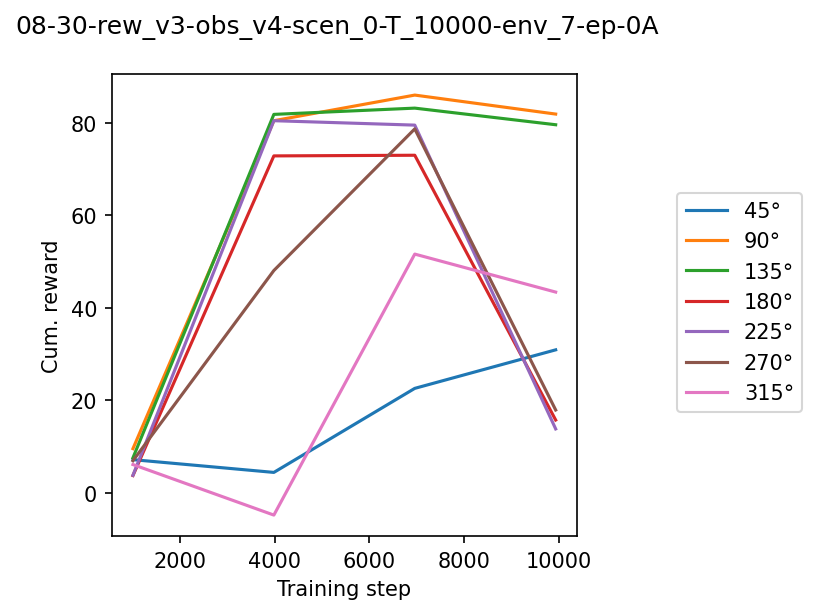

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

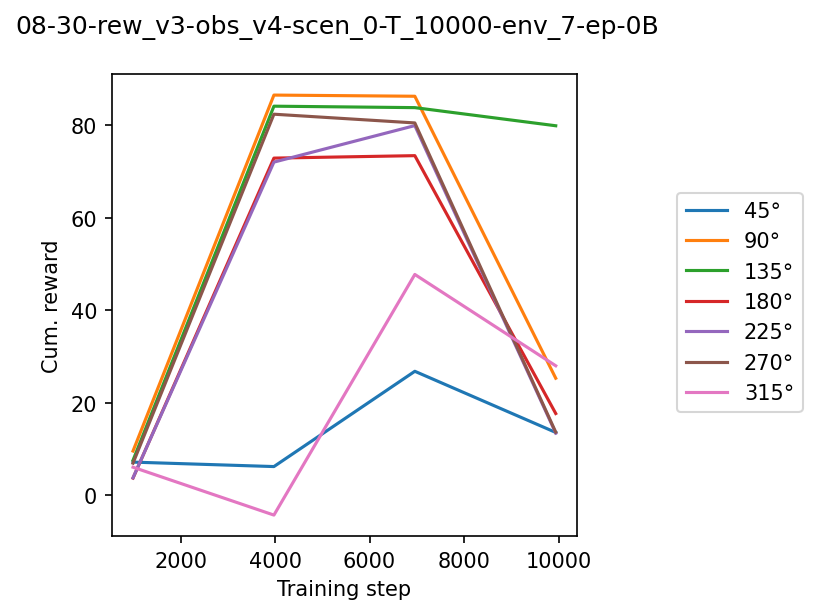

In [5]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B')

## Episode duration = **100s**

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                100                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

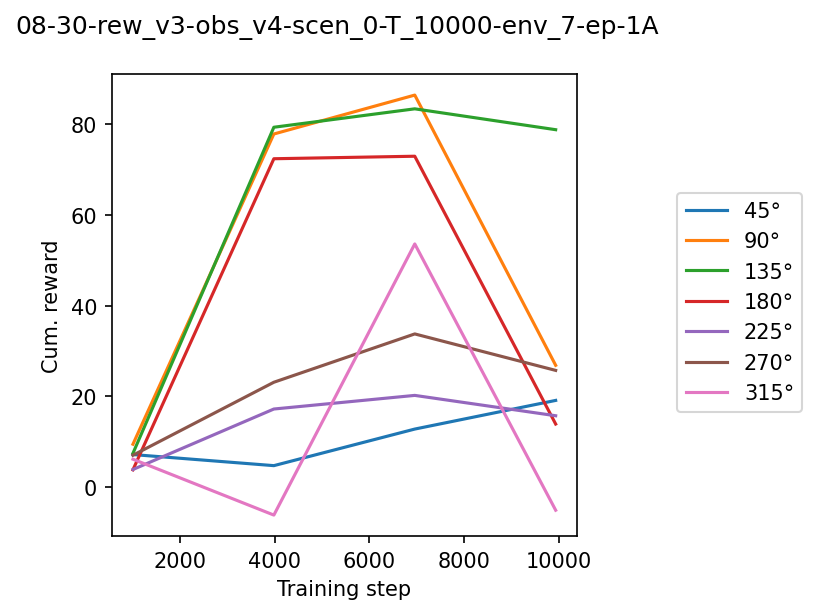

Found 1 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                100                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

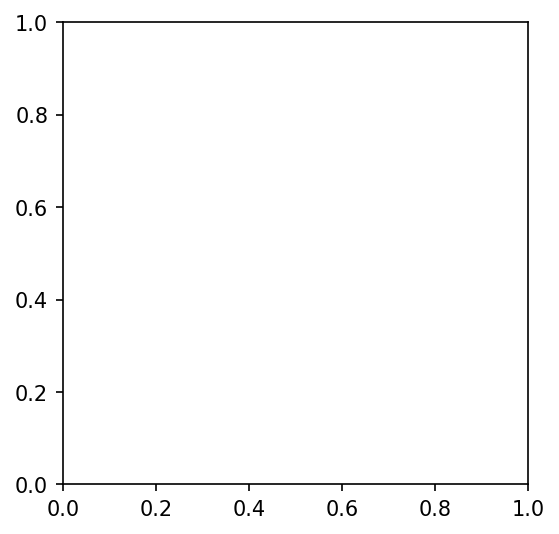

In [6]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B')

## Episode duration = **50**

Found 1 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                 50                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

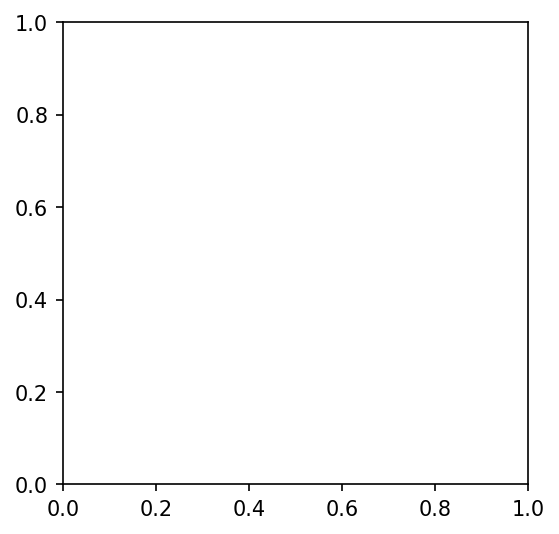

In [8]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B')

# Testing with stable observations and VMC reward
- **Last score: 62**
- **Changes:**
  - **gain dist -> VMC**: VMC reward is more stable than gain dist
  - **TAE-> heading error**: TAE is noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).
- **Results:** VMC + 0.01 * heading error seems better (more stable)

## VMC + .001*penalty

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v1            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

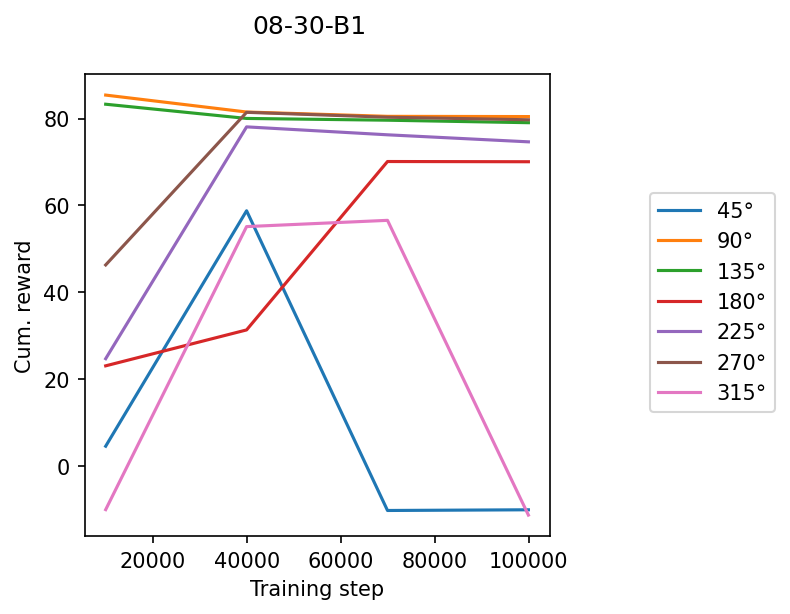

In [9]:
plot_training_evolution('08-30-B1')

## VMC + .005*penalty

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v2            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

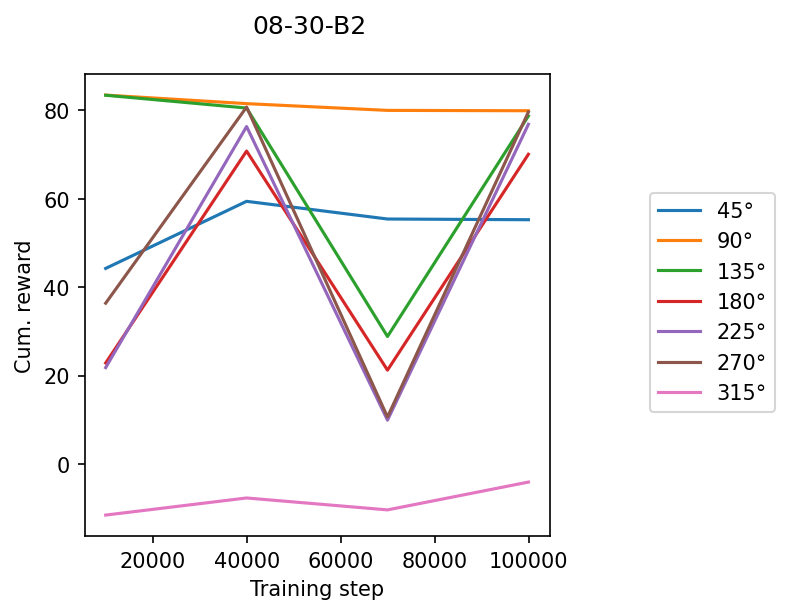

In [10]:
plot_training_evolution('08-30-B2')

## VMC + .01*penalty

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

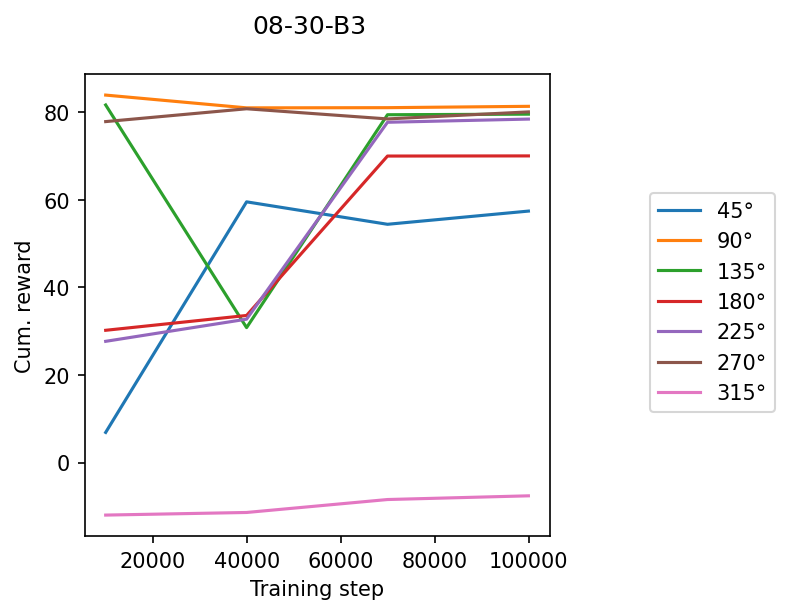

In [11]:
plot_training_evolution('08-30-B3')

## VMC + .05*penalty

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v4            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

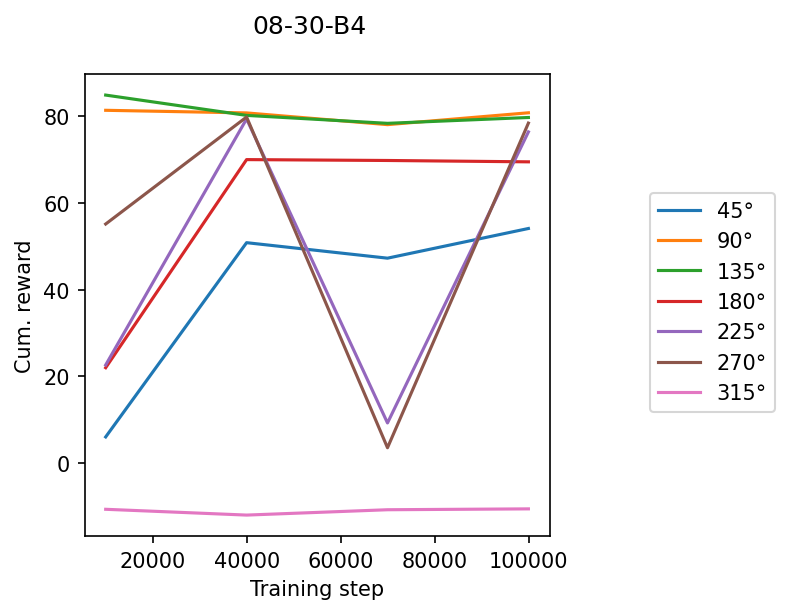

In [12]:
plot_training_evolution('08-30-B4')

## VMC + .1*penalty

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v5            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

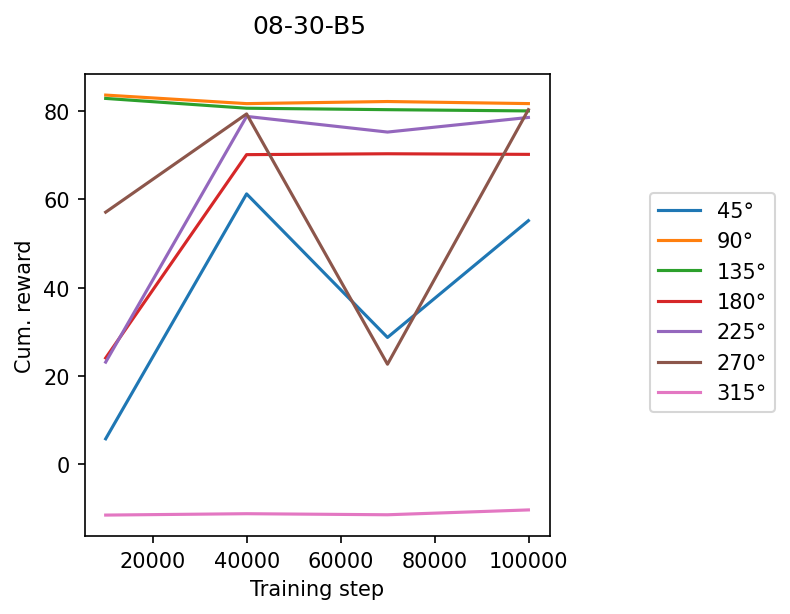

In [13]:
plot_training_evolution('08-30-B5')

## VMC + .5*penalty

```bash
screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_vmc_v1 --obs=basic_2d_obs_v4 --total=100000 --n-envs=7 --name="08-30-B6"
```

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v6            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

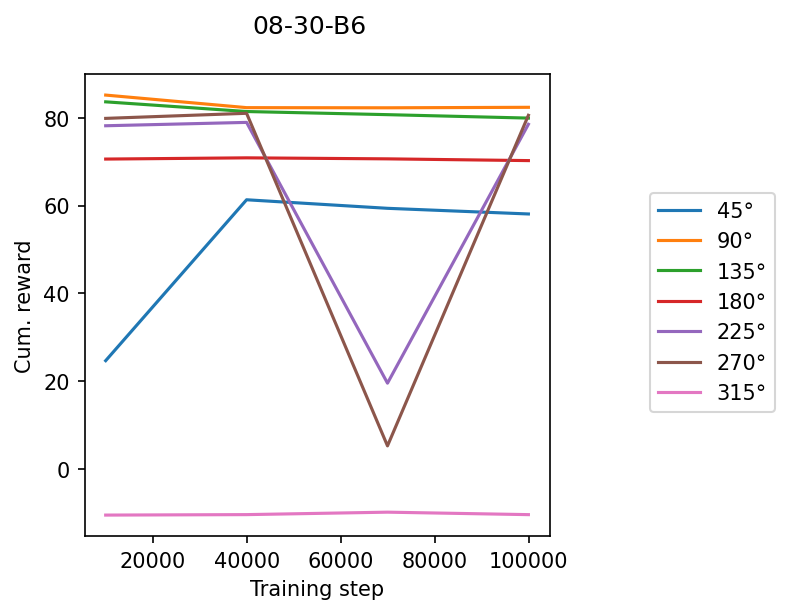

In [14]:
plot_training_evolution('08-30-B6')

# Trying with greater learning rate but **3e-5** seems the best
**Last score:** 63

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

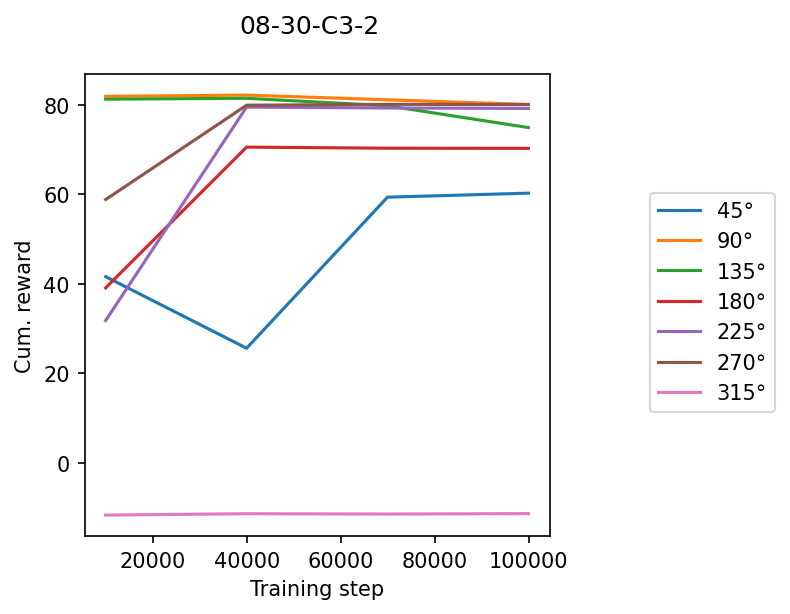

In [15]:
plot_training_evolution('08-30-C3-2')

Found 14 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

ValueError: x and y must have same first dimension, but have shapes (6,) and (12,)

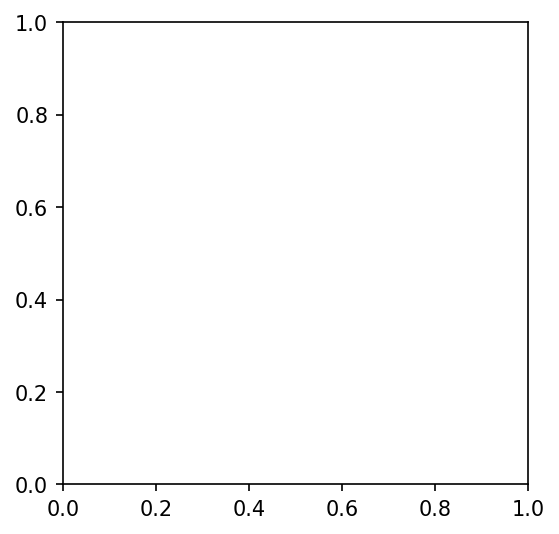

In [16]:
plot_training_evolution('08-30-C3')

# Trying with different network architecture the original one seems the best
**Last score:** 63

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v7            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

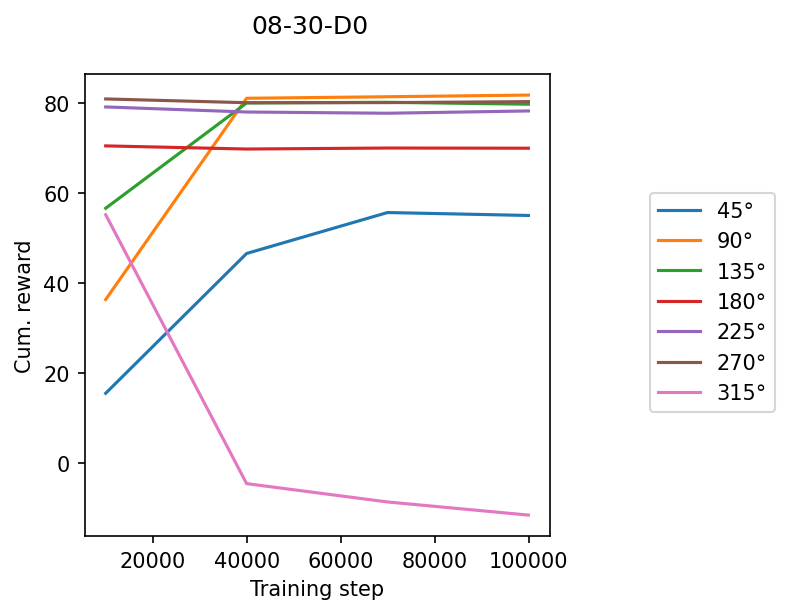

In [25]:
plot_training_evolution('08-30-D0')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v7            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

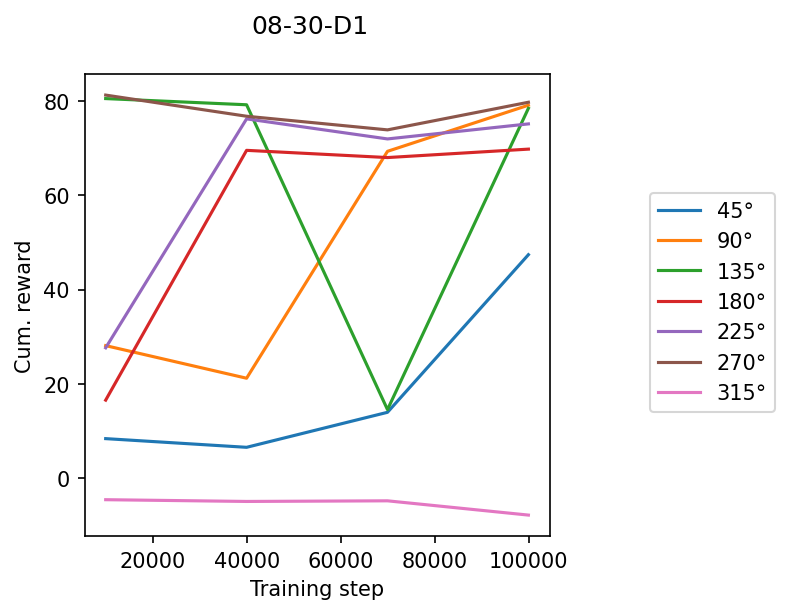

In [26]:
plot_training_evolution('08-30-D1')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v7            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

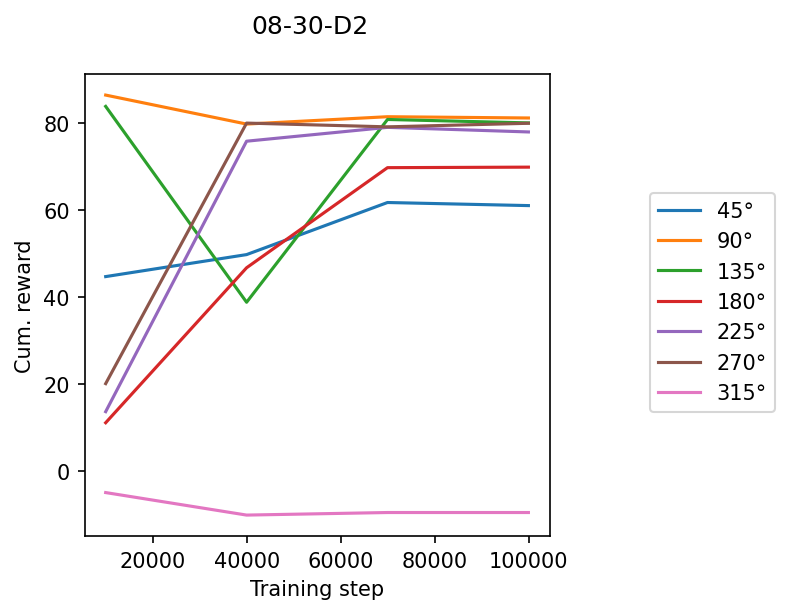

In [27]:
plot_training_evolution('08-30-D2')

# Debug: why does E0 is not learning? Probably because of the sparse reward
**Last score:** 71.6

Found 8 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v8            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

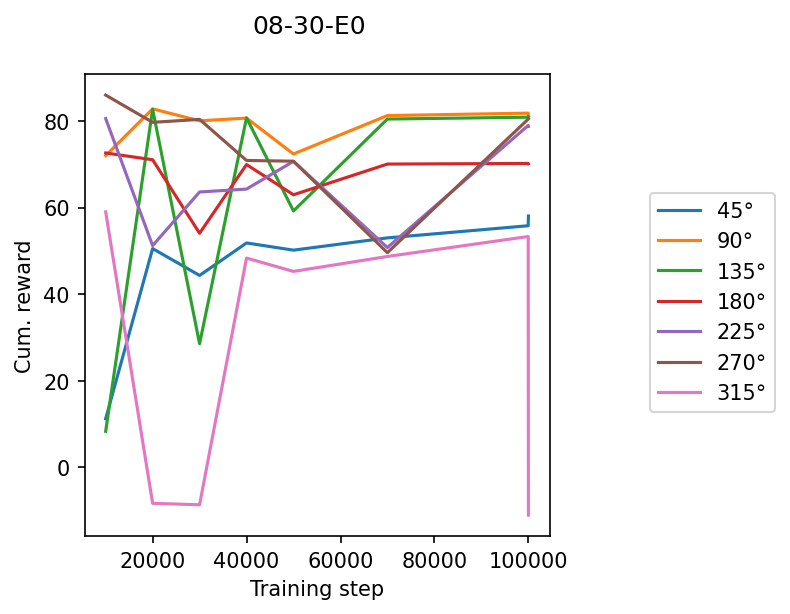

In [28]:
plot_training_evolution('08-30-E0')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |             max_vmc_v8            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

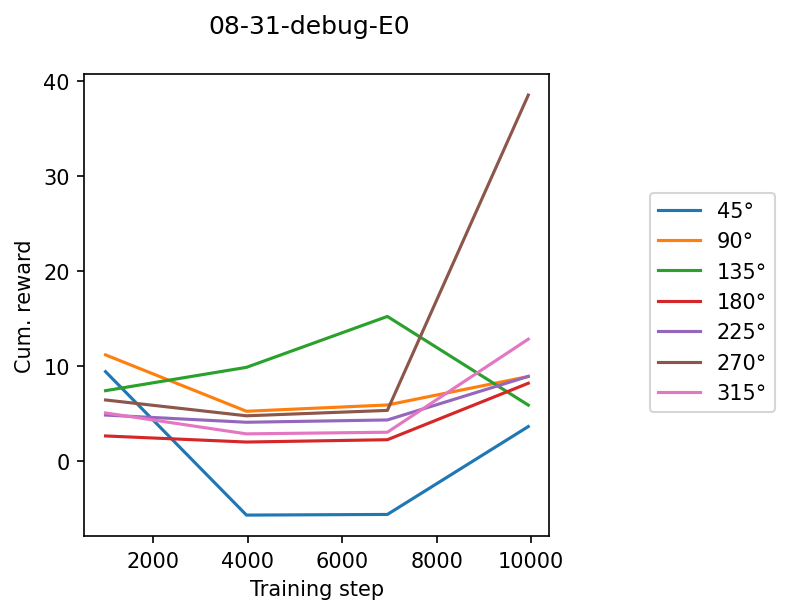

In [29]:
plot_training_evolution('08-31-debug-E0')

Failed to load 1 files for 08-31-debug-2-E0-19950/**/*


<Axes: xlabel='Timesteps', ylabel='act/mlp'>

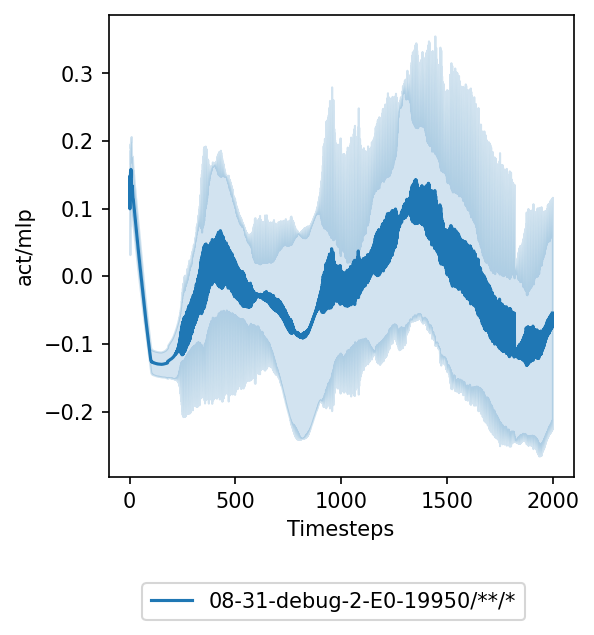

In [30]:
from utils import plot_metric

plot_metric(
  [
    # '08-31-debug-E0-994/**/*',
    # '08-31-debug-E0-3976/**/*',
    # '08-31-debug-E0-6958/**/*',
    # '08-30-E0-19992/**/*',
    # '08-31-debug-2-E0-19950/**/*',

    # '08-31-debug-2-E0-1995/**/*',
    # '08-31-debug-2-E0-3990/**/*',
    # '08-31-debug-2-E0-5985/**/*',
    # '08-31-debug-2-E0-7980/**/*',
    # '08-31-debug-2-E0-9975/**/*',
    # '08-31-debug-2-E0-11970/**/*',
    # '08-31-debug-2-E0-13965/**/*',
    # '08-31-debug-2-E0-15960/**/*',
    # '08-31-debug-2-E0-17955/**/*',
    '08-31-debug-2-E0-19950/**/*',
  ],
  metric='act/mlp')

Failed to load 1 files for 08-30-E0-9996/**/*


Failed to load 1 files for 08-30-E0-19992/**/*


<Axes: xlabel='Timesteps', ylabel='act/mlp'>

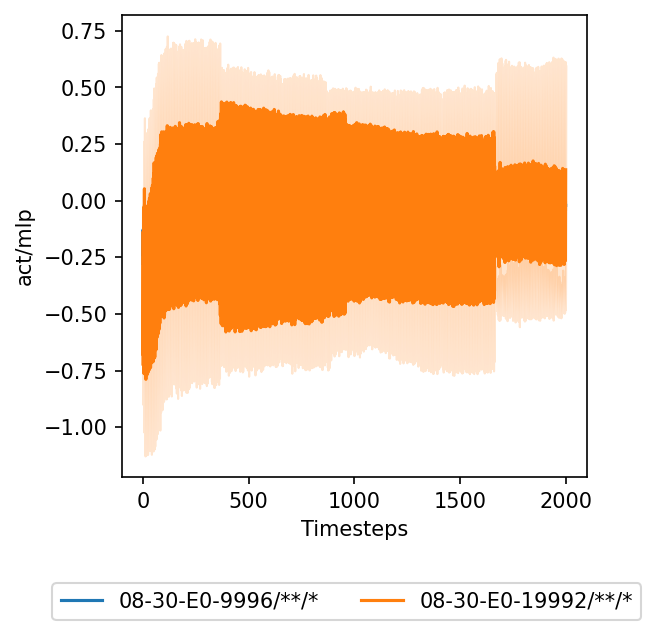

In [31]:
plot_metric(
  [
    '08-30-E0-9996/**/*',
    '08-30-E0-19992/**/*',
  ],
  metric='act/mlp')

# Creating a shaped reward

## V1

### 1D reward (min xte)
- **Idea:** Reward the agent to be inside the corridor

### 1D reward (min tae)

### 1D reward (max vmc)

### 2D reward (max vmc & min xte)

(40, 39) (40, 40)


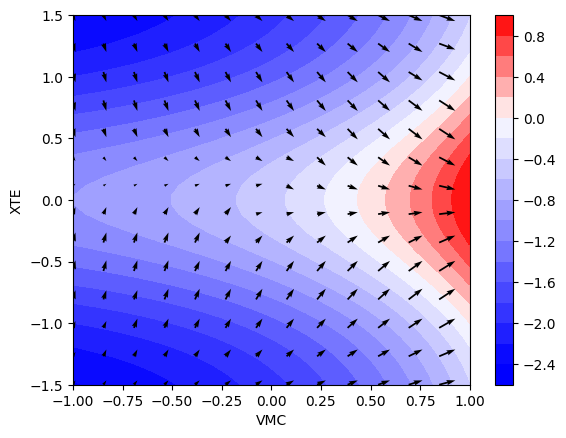

In [114]:
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
r_xte = (np.exp(-(Y**2-1))-1)/(np.e - 1) - 1

R = r_vmc + r_xte

# define the colormap
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> G -> B
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

norm = TwoSlopeNorm(vmin=R.min(), vcenter=0, vmax=R.max())

plt.contourf(X, Y, R, levels=19, cmap=cm, norm=norm)
plt.xlabel('VMC')
plt.ylabel('XTE')
plt.colorbar()

# compute the gradient
dR_dx = np.diff(R, axis=1) / np.diff(X, axis=1)
dR_dy = np.diff(R, axis=0) / np.diff(Y, axis=0)
print(dR_dx.shape, X.shape)

# plot the gradient vectors as arrows
X, Y = X[:, :-1], Y[:, :-1]

plt.quiver(X[::3, ::3], Y[::3, ::3], dR_dx[::3, ::3], dR_dy[::3, ::3], scale=50)

plt.show()

### 3D reward (max vmc & min xte)

In [109]:
n = 30

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
print(f'vmc: {r_vmc.min()}, {r_vmc.max()}')

r_xte = (np.exp(-(Y**2-1))-1)/(np.e - 1) - 1
print(f'xte: {r_vmc.min()}, {r_vmc.max()}')

R = r_vmc + r_xte
print(f'reward: {R.min()}, {R.max()}')

# define the colorscale
norm_zero = -min_R / (max_R - min_R)
colorscale = [[0, 'blue'], [norm_zero, 'white'], [1, 'red']]

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=R, x=X, y=Y, colorscale=colorscale)])
fig.update_layout(title='3D Surface Plot of R', autosize=False,
                  width=500, height=500, margin=dict(t=40, b=40, l=40, r=40),
                  scene=dict(xaxis_title='VMC', yaxis_title='XTE', zaxis_title='R'),
                  scene_camera=dict(
                      up=dict(x=0, y=0, z=1),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-1.5, y=1.5, z=1.5)
                  ))
fig.show()

vmc: -1.0, 1.0
xte: -1.0, 1.0
reward: -2.415237588690368, 0.9989777944598282


In [158]:
n = 30

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

r_vmc = X
print(f'vmc: {r_vmc.min()}, {r_vmc.max()}')

r_xte = -np.abs(Y)
print(f'xte: {r_vmc.min()}, {r_vmc.max()}')

R = r_vmc + r_xte
print(f'reward: {R.min()}, {R.max()}')

# define the colorscale
norm_zero = -min_R / (max_R - min_R)
colorscale = [[0, 'blue'], [norm_zero, 'white'], [1, 'red']]

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=R, x=X, y=Y, colorscale=colorscale)])
fig.update_layout(title='3D Surface Plot of R', autosize=False,
                  width=500, height=500, margin=dict(t=40, b=40, l=40, r=40),
                  scene=dict(xaxis_title='VMC', yaxis_title='XTE', zaxis_title='R'),
                  scene_camera=dict(
                      up=dict(x=0, y=0, z=1),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-1.5, y=1.5, z=1.5)
                  ))
fig.show()

vmc: -1.0, 1.0
xte: -1.0, 1.0
reward: -2.5, 0.9745762711864407


### 3D reward (max vmc & min xte & min heading error)

In [130]:
import numpy as np
import plotly.graph_objects as go

n = 10

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1.5))
tae = np.linspace(-np.pi, np.pi, int(n*2*np.pi))

X, Y, Z = np.meshgrid(vmc, xte, tae)
r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
r_xte = 2*(np.exp(-(Y**2-1))-1)/(np.e - 1) - 1
r_tae = 2*(np.exp(np.cos(Z)+1) - 1) / (np.exp(2) - 1) - 1

R = r_vmc + r_xte + r_tae

# Convert the R values into a color
colorscale = 'Viridis'
color = R.flatten()

# Plotting the data
fig = go.Figure(data=[go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    mode='markers',
    marker=dict(
        size=2,
        color=color,                # set color to an array/list of desired values
        colorscale=colorscale,      # choose a colorscale
        opacity=0.8,
        colorbar=dict(
            title='R Value'       # colorbar title
        )
    )
)])

# Update layout for axis labels and other settings
fig.update_layout(
    margin=dict(t=0, b=0, l=0, r=0),
    scene=dict(
        xaxis_title='VMC',
        yaxis_title='XTE',
        zaxis_title='TAE'
    )
)

fig.show()

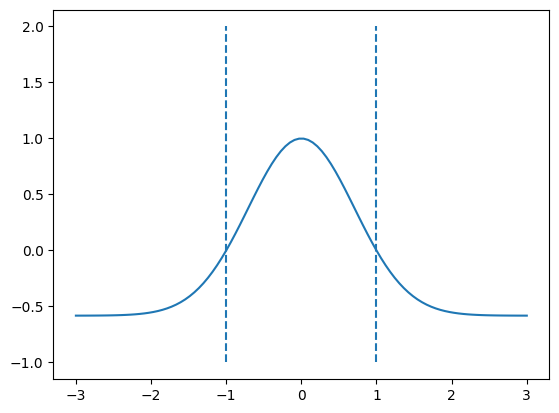

In [34]:
xte = np.linspace(-3, 3, 100)

r = (np.exp(-((xte)**2-1))-1) / (np.e - 1)

plt.plot(xte, r)
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

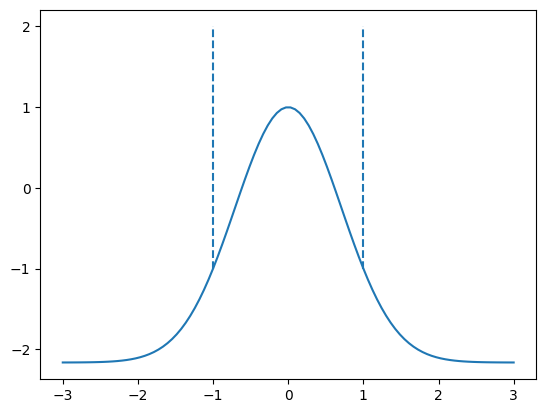

In [35]:
xte = np.linspace(-3, 3, 100)

r = 2*(np.exp(-((xte)**2-1))-1) / (np.e - 1) - 1

plt.plot(xte, r)
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

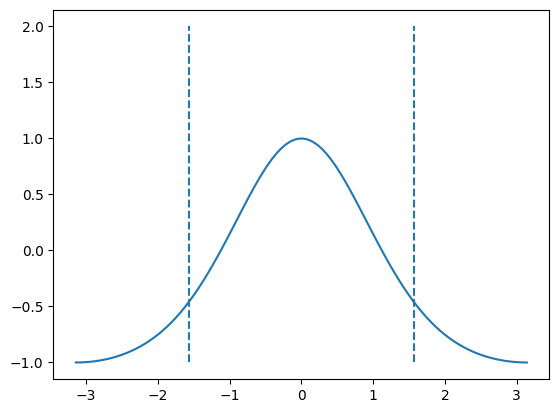

In [47]:
heading = np.linspace(-np.pi, np.pi, 100)

r = 2*(np.exp(np.cos(heading)+1) - 1) / (np.exp(2) - 1) - 1

plt.plot(heading, r)
plt.vlines(-np.pi/2, -1, 2, linestyles='dashed')
plt.vlines(np.pi/2, -1, 2, linestyles='dashed')

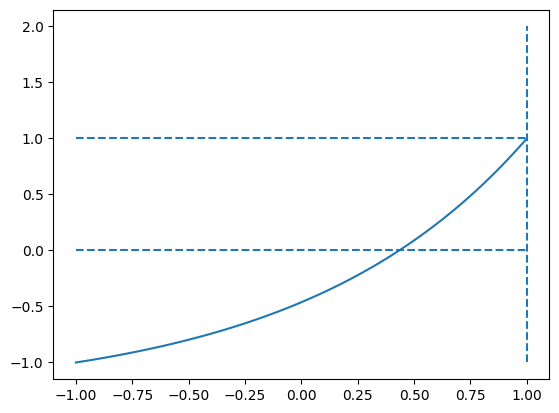

In [48]:
vmc = np.linspace(-1, 1, 100)

r = 2*(np.exp(vmc+1) - 1) / (np.exp(2) - 1) - 1

plt.plot(vmc, r)
plt.vlines(1, -1, 2, linestyles='dashed')
plt.hlines(1, -1, 1, linestyles='dashed')
plt.hlines(0, -1, 1, linestyles='dashed')

## V2

In [36]:
def f_sigm_inf(a, x, delta=1, eps=1e-2):
    A = np.exp(-a)
    A_x = np.exp(-a * x)
    A_delta = np.exp(-a * delta)
    B = (eps - A_delta) / (A_delta * (1 - eps))
    return (A_x * (B + 1)) / (A_x * B + 1)


def f_sigm_bounded(a, x, bound=[-1, 1]):
    def sig(x):
        return 1 / (1 + np.exp(-a * x))
    return (1 - sig(x) - sig(bound[0])) / (sig(bound[1]) - sig(bound[0]))


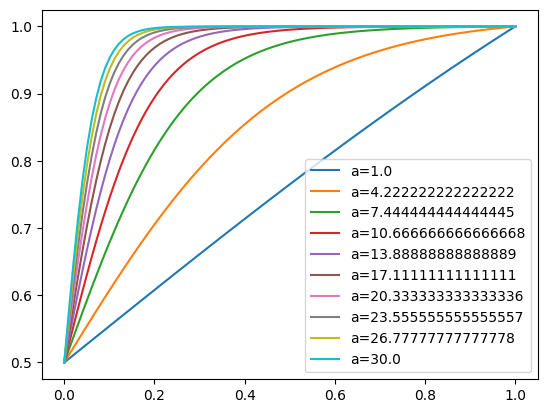

In [169]:
x = np.linspace(0, 1, 100)

def sig_norm(x, center=0, a=None, x_delta_to_center=.1, y_delta_from_1=.1, bound=[-1, 1]):
  def sig(x):
    nonlocal a
    if a is None:
      a = np.log(y_delta_from_1/(1-y_delta_from_1))/x_delta_to_center
    b = -center
    return 1/(1+np.exp(-a*(x+b)))
  return (sig(x) - sig(bound[0])) / (sig(bound[1]) - sig(bound[0]))

for a in np.linspace(1, 30, 10):
  plt.plot(x, sig_norm(x, a=a), label=f'a={a}')
plt.legend()

# y_delta_from_1 = .9
# x_delta_to_center = .4
# plt.plot(x, -sig_norm(x, x_delta_to_center=x_delta_to_center, y_delta_from_1=y_delta_from_1))
# plt.vlines(x_delta_to_center, -1, 1, linestyles='dashed')
# plt.hlines(-y_delta_from_1, -1, 1, linestyles='dashed')

### XTE

In [146]:
# def xte_reward(xte, dist, penality):
#   s = sig_norm(
#     np.abs(xte),
#     x_delta_to_center=1-dist,
#     y_delta_from_1=-penality,
#     center=1,
#     bound=[0, 2]
#   )
#   return -s

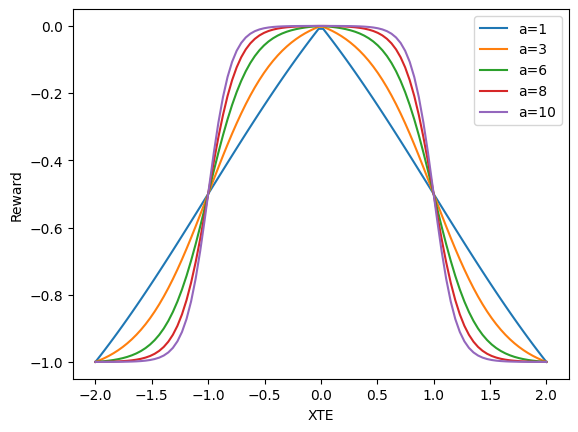

In [147]:
xte = np.linspace(-2, 2, 100)

def xte_reward(xte, steepness):
  s = sig_norm(
    np.abs(xte),
    a=steepness,
    center=1,
    bound=[0, 2]
  )
  return -s

for a in np.linspace(1, 10, 5):
  plt.plot(xte, xte_reward(xte, a), label=f'a={a:.0f}')
plt.xlabel('XTE')
plt.ylabel('Reward')
plt.legend()

### VMC

In [148]:
# def vmc_reward(vmc, start_penality=.75, desired_vmc=.9, desired_vmc_reward=.9):
#   # s = sig_norm(
#   #   vmc,
#   #   center=start_penality,
#   #   delta=.1,
#   #   eps=(1-.1)*.5)
#   desired_vmc_reward = (desired_vmc_reward+1)/2
#   s = sig_norm(
#     vmc,
#     center=start_penality,
#     x_delta_to_center=start_penality-(1-desired_vmc),
#     y_delta_from_1=1-desired_vmc_reward,
#   )
#   return 2*s-1

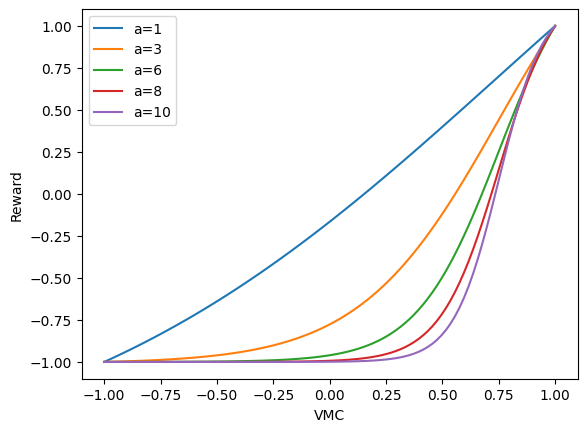

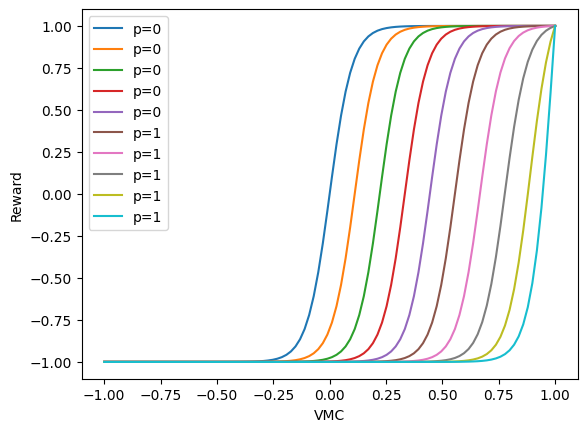

In [170]:
vmc = np.linspace(-1, 1, 100)

def vmc_reward(vmc, start_penality=.75, steepness=1):
  s = sig_norm(
    vmc,
    center=start_penality,
    a=steepness,
  )
  return 2*s-1

for a in np.linspace(1, 10, 5):
  plt.plot(vmc, vmc_reward(vmc, steepness=a), label=f'a={a:.0f}')
plt.xlabel('VMC')
plt.ylabel('Reward')
plt.legend()
plt.show()

for p in np.linspace(0, 1, 10):
  plt.plot(vmc, vmc_reward(vmc, steepness=20, start_penality=p), label=f'p={p:.0f}')
plt.xlabel('VMC')
plt.ylabel('Reward')
plt.legend()

### 2D reward (max vmc & min xte)

-1.0 1.0
-0.7902271786401751 -0.012638114818477458
0.9873618851815226 -1.790227178640175
(40, 39) (40, 40)


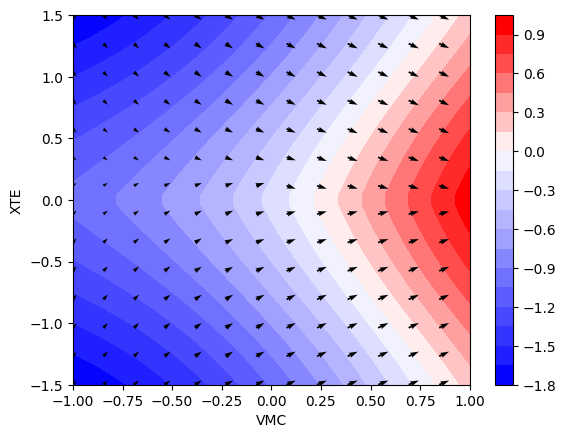

In [152]:
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# best scenario 0
# vmc_reward = partial(vmc_reward, start_penality=.57, steepness=18.8)
# xte_reward = partial(xte_reward, steepness=2.5)

# best scenario 1
# vmc_reward = partial(vmc_reward, start_penality=-1, steepness=1.7)
# xte_reward = partial(xte_reward, steepness=8)

# best scenario 2
vmc_reward = partial(vmc_reward, start_penality=.6, steepness=1.4)
xte_reward = partial(xte_reward, steepness=1.7)

n = 20

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

# VMC reward
r_vmc = vmc_reward(X)
print(r_vmc.min(), r_vmc.max())

# XTE penalty:
r_xte = xte_reward(Y)
print(r_xte.min(), r_xte.max())

R = r_vmc + r_xte

print(R.max(), R.min())


# define the colormap
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> G -> B
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom1'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

norm = TwoSlopeNorm(vmin=R.min(), vcenter=0, vmax=R.max())

plt.contourf(X, Y, R, levels=19, cmap=cm, norm=norm)
plt.xlabel('VMC')
plt.ylabel('XTE')
plt.colorbar()

# compute the gradient
dR_dx = np.diff(R, axis=1) / np.diff(X, axis=1)
dR_dy = np.diff(R, axis=0) / np.diff(Y, axis=0)
print(dR_dx.shape, X.shape)

# plot the gradient vectors as arrows
X, Y = X[:, :-1], Y[:, :-1]

plt.quiver(X[::3, ::3], Y[::3, ::3], dR_dx[::3, ::3], dR_dy[::3, ::3], scale=50)

plt.show()

### 3D reward (max vmc & min xte)

In [156]:
n = 30

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

# VMC reward
r_vmc = vmc_reward(X)
print(f'vmc: {r_vmc.min()}, {r_vmc.max()}')

# XTE penalty:
r_xte = xte_reward(Y)
print(f'xte: {r_vmc.min()}, {r_vmc.max()}')

R = r_vmc + r_xte
print(f'reward: {R.min()}, {R.max()}')

# define the colorscale
# calculate normalized values
min_R = R.min()
max_R = R.max()
norm_zero = -min_R / (max_R - min_R)

# define the colorscale
colorscale = [[0, 'blue'], [norm_zero, 'white'], [1, 'red']]

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=R, x=X, y=Y, colorscale=colorscale)])
fig.update_layout(title='3D Surface Plot of R', autosize=False,
                  width=500, height=500, margin=dict(t=40, b=40, l=40, r=40),
                  scene=dict(xaxis_title='VMC', yaxis_title='XTE', zaxis_title='R'),
                  scene_camera=dict(
                      up=dict(x=0, y=0, z=1),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-0.5, y=1.5, z=2)
                  ))
fig.show()

vmc: -1.0, 1.0
xte: -1.0, 1.0
reward: -1.790227178640175, 0.9917092302574946


# Testing with shaped reward (max VMC & min XTE)
- **Last score:** 70.4
- **Result:** Good learning! Still noisy

Found 10 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |         max_vmc_min_xte_v1        |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

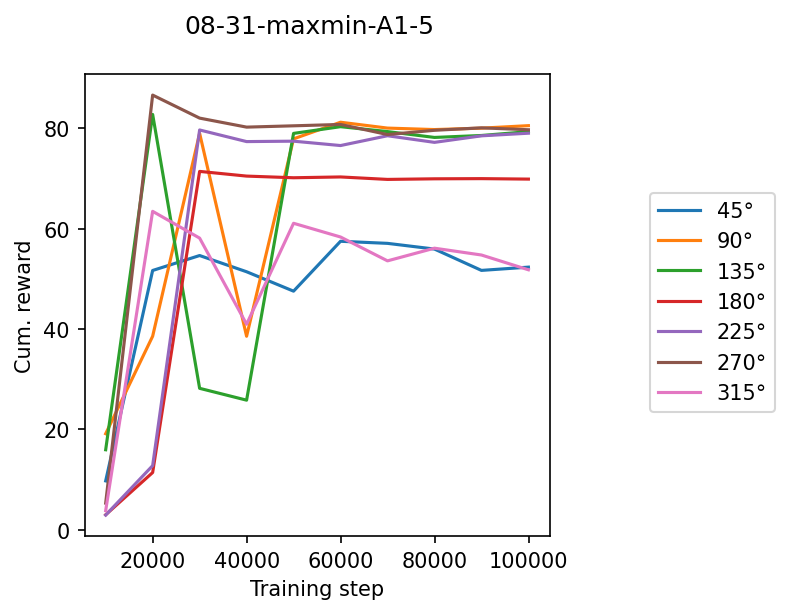

In [49]:
plot_training_evolution('08-31-maxmin-A1-5', model_folder='08-31-maxmin-A1')

<Axes: xlabel='Timesteps', ylabel='obs/dt_theta_rudder/0'>

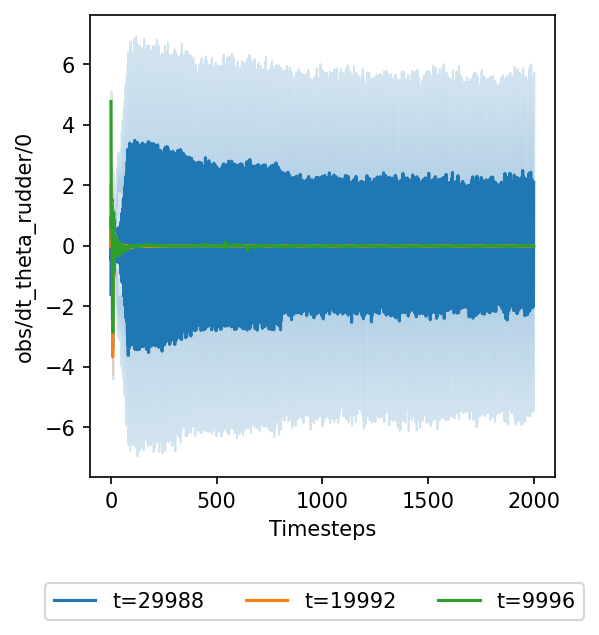

In [50]:
plot_metric(
  [
    ('08-31-maxmin-A1-5-29988/eval-*/0', 't=29988'),
    ('08-31-maxmin-A1-5-19992/eval-*/0', 't=19992'),
    ('08-31-maxmin-A1-5-9996/eval-*/0', 't=9996'),
  ],
  metric='obs/dt_theta_rudder/0',
)

# Is penalizing the XTE a good idea or just rewarded for being in the corridor is enough? **penalizing XTE**
- **Last score:** 74
- **Result:** Good learning! But still doing noisy actions.

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |  max_vmc_min_xte_penalize_xte_v1  |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

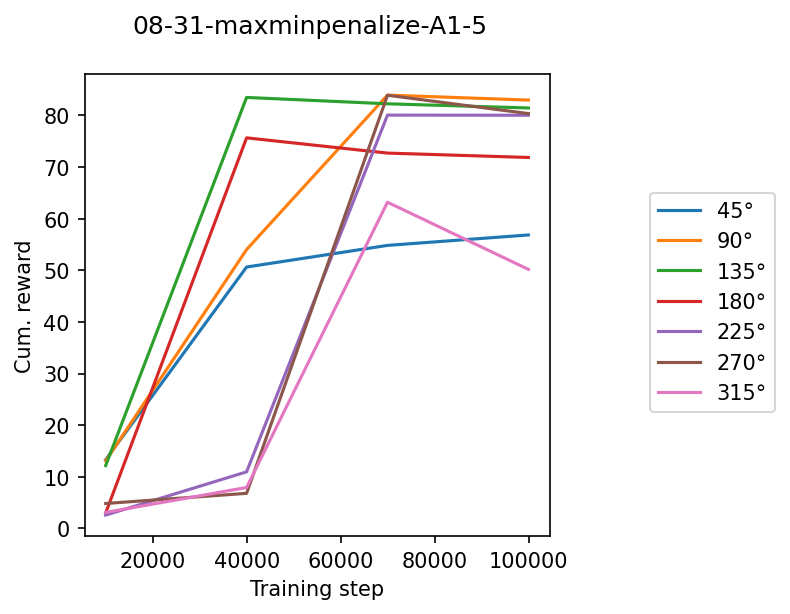

In [53]:
plot_training_evolution('08-31-maxminpenalize-A1-5', model_folder='08-31-maxminpenalize-A1')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |  max_vmc_min_xte_penalize_xte_v2  |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

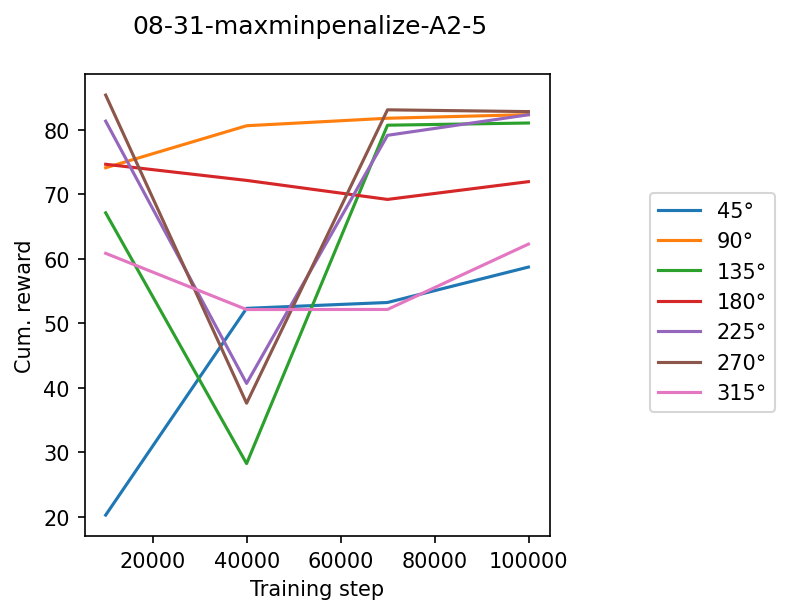

In [54]:
plot_training_evolution('08-31-maxminpenalize-A2-5', model_folder='08-31-maxminpenalize-A2')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |  max_vmc_min_xte_penalize_xte_v3  |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

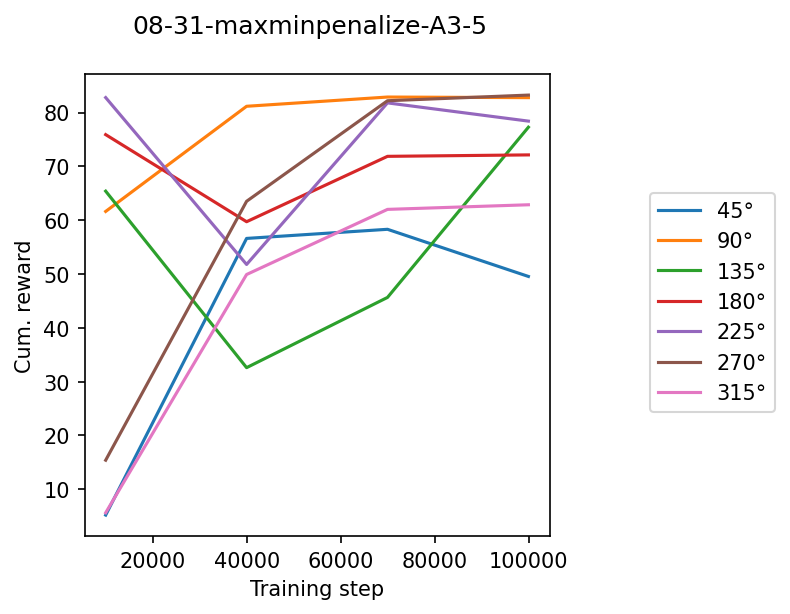

In [55]:
plot_training_evolution('08-31-maxminpenalize-A3-5', model_folder='08-31-maxminpenalize-A3')

<Axes: >

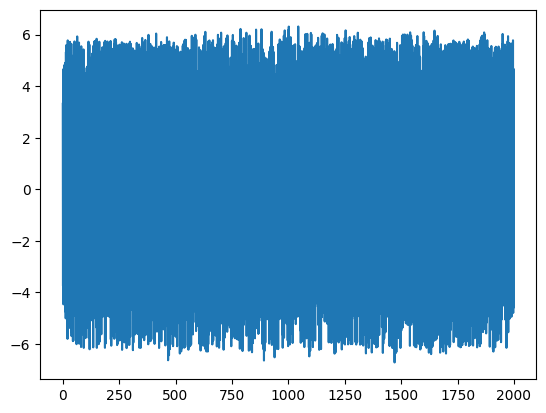

In [56]:
dfs = get_dfs('08-31-maxminpenalize-A1-5-99960/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot()

# Is penalizing delta rudder a good idea? **penalizing delta rudder**

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |  max_vmc_min_xte_min_dt_rudder_v1 |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

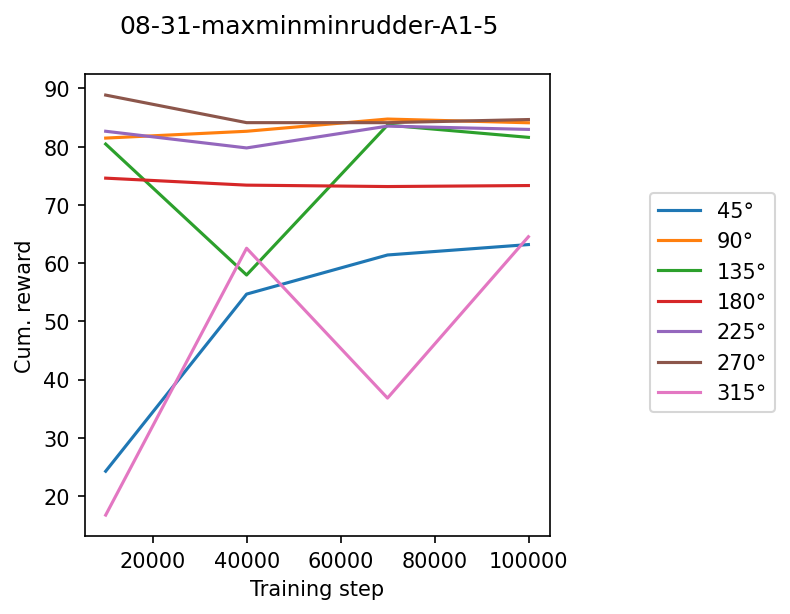

In [57]:
plot_training_evolution('08-31-maxminminrudder-A1-5', model_folder='08-31-maxminminrudder-A1')

<Axes: >

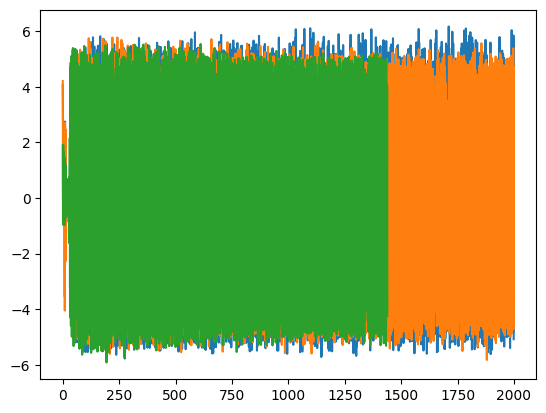

In [58]:
dfs = get_dfs('08-31-maxminminrudder-A1-5-99960/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='10K')

dfs = get_dfs('08-31-maxminminrudder-A1-5-69972/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='7K')

dfs = get_dfs('08-31-maxminminrudder-A1-5-39984/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='4K')

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |  max_vmc_min_xte_min_dt_rudder_v1 |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

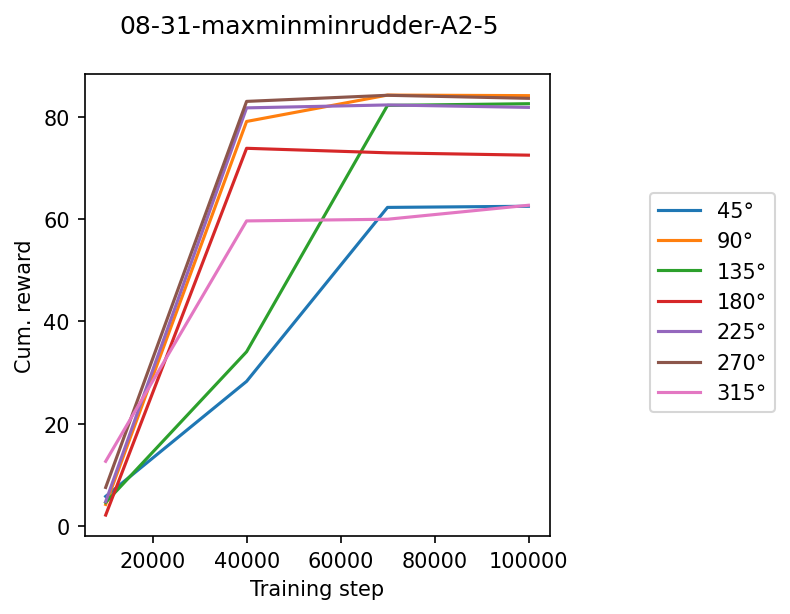

In [59]:
plot_training_evolution('08-31-maxminminrudder-A2-5', model_folder='08-31-maxminminrudder-A2')

<Axes: >

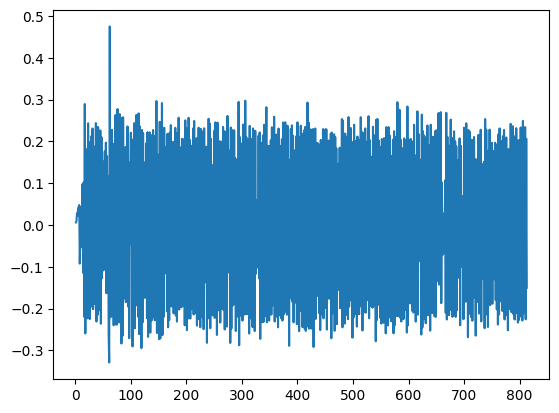

In [60]:
# dfs = get_dfs('08-31-maxminpenalize-A1-5-99960/eval-*/0/')
# df = dfs.popitem()[1]
# df['obs/dt_theta_rudder/0'].plot()

dfs = get_dfs('08-31-maxminminrudder-A3-5-39984/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/theta_rudder/0'].diff().plot()
# plt.hlines(np.pi/2, 0, 1000, linestyles='dashed')
# plt.hlines(-np.pi/2, 0, 1000, linestyles='dashed')
# (df['obs/dt_theta_rudder/0']*.1).plot()
# plt.xlim(100, 200)

Found 4 files


Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |  max_vmc_min_xte_min_dt_rudder_v1 |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 16                |
|       gamma       |               0.999               |
|   l

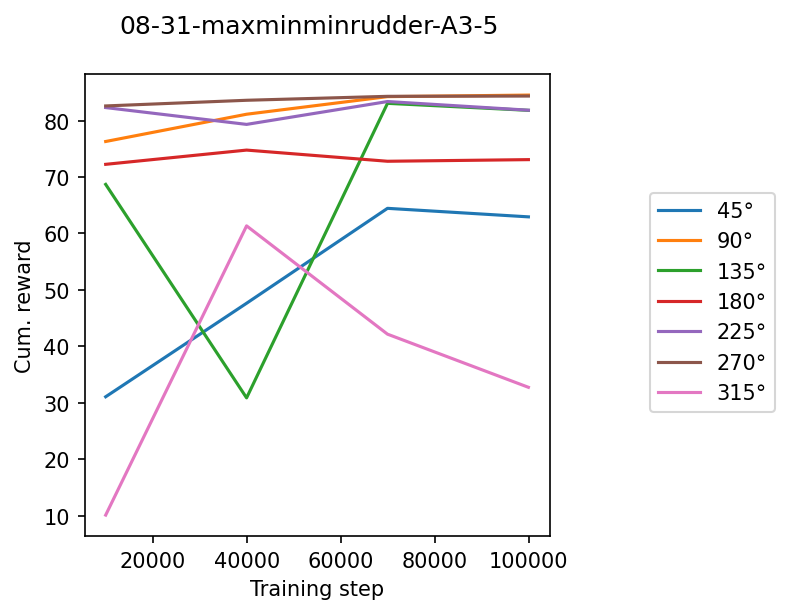

In [61]:
plot_training_evolution('08-31-maxminminrudder-A3-5', model_folder='08-31-maxminminrudder-A3')

Found 4 files


Hparams:
+-------------------+---------------------------------------+
|        Name       |                 Value                 |
+-------------------+---------------------------------------+
|        obs        |            basic_2d_obs_v4            |
|        act        |            rudder_angle_act           |
|       reward      | max_vmc_penalize_xte_and_dt_rudder_v1 |
|  episode_duration |                  200                  |
|       n_envs      |                   7                   |
|   water_current   |                  none                 |
|        wind       |                constant               |
|     wind_dirs     |   [45, 90, 135, 180, 225, 270, 315]   |
| water_current_dir |                   90                  |
|  keep_sim_running |                 False                 |
|   container_tag   |                mss1-ode               |
|      n_steps      |                  1024                 |
|     batch_size    |                   16                  |

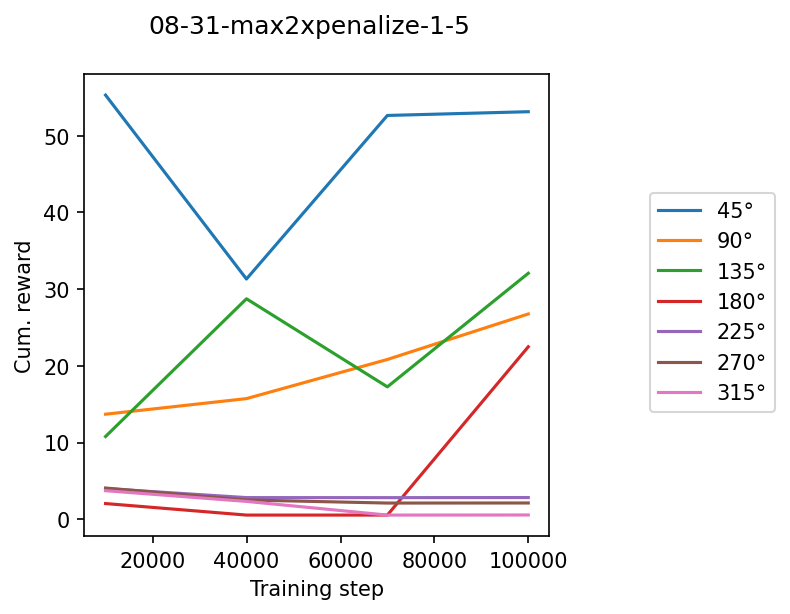

In [62]:
plot_training_evolution('08-31-max2xpenalize-1-5', model_folder='08-31-max2xpenalize-1')


Found 4 files


Hparams:
+-------------------+---------------------------------------+
|        Name       |                 Value                 |
+-------------------+---------------------------------------+
|        obs        |            basic_2d_obs_v4            |
|        act        |            rudder_angle_act           |
|       reward      | max_vmc_penalize_xte_and_dt_rudder_v2 |
|  episode_duration |                  200                  |
|       n_envs      |                   7                   |
|   water_current   |                  none                 |
|        wind       |                constant               |
|     wind_dirs     |   [45, 90, 135, 180, 225, 270, 315]   |
| water_current_dir |                   90                  |
|  keep_sim_running |                 False                 |
|   container_tag   |                mss1-ode               |
|      n_steps      |                  1024                 |
|     batch_size    |                   16                  |

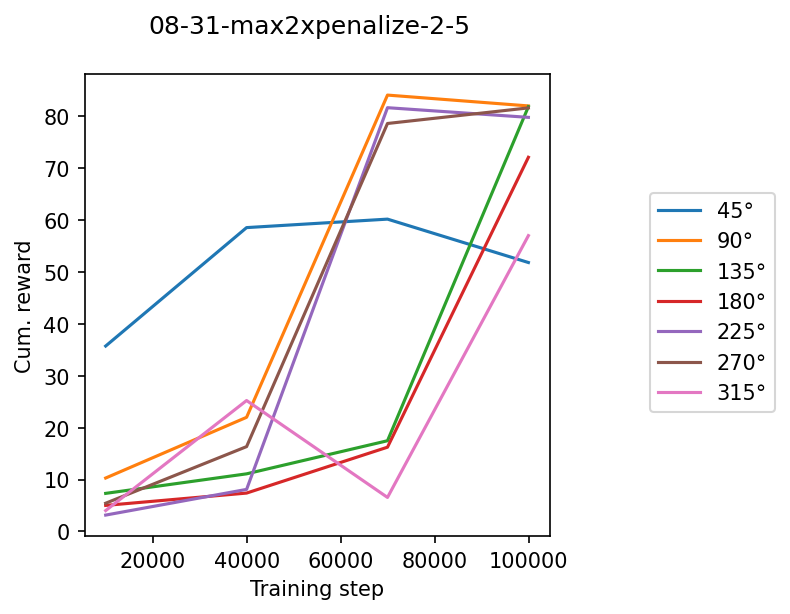

In [63]:
plot_training_evolution('08-31-max2xpenalize-2-5', model_folder='08-31-max2xpenalize-2')

Found 4 files


Hparams:
+-------------------+---------------------------------------+
|        Name       |                 Value                 |
+-------------------+---------------------------------------+
|        obs        |            basic_2d_obs_v4            |
|        act        |            rudder_angle_act           |
|       reward      | max_vmc_penalize_xte_and_dt_rudder_v3 |
|  episode_duration |                  200                  |
|       n_envs      |                   7                   |
|   water_current   |                  none                 |
|        wind       |                constant               |
|     wind_dirs     |   [45, 90, 135, 180, 225, 270, 315]   |
| water_current_dir |                   90                  |
|  keep_sim_running |                 False                 |
|   container_tag   |                mss1-ode               |
|      n_steps      |                  1024                 |
|     batch_size    |                   16                  |

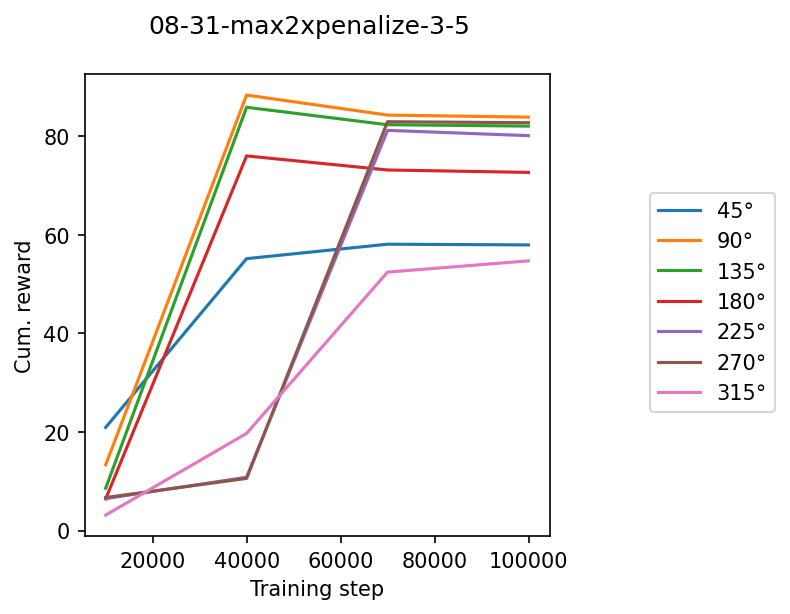

In [64]:
plot_training_evolution('08-31-max2xpenalize-3-5', model_folder='08-31-max2xpenalize-3')

Found 10 files


Hparams:
+-------------------+------------------------------------------+
|        Name       |                  Value                   |
+-------------------+------------------------------------------+
|        obs        |             basic_2d_obs_v5              |
|        act        |             rudder_angle_act             |
|       reward      | max_vmc_penalize_xte_and_delta_rudder_v2 |
|  episode_duration |                   200                    |
|       n_envs      |                    7                     |
|   water_current   |                   none                   |
|        wind       |                 constant                 |
|     wind_dirs     |    [45, 90, 135, 180, 225, 270, 315]     |
| water_current_dir |                    90                    |
|  keep_sim_running |                  False                   |
|   container_tag   |                 mss1-ode                 |
|      n_steps      |                   1024                   |
|     batch_size

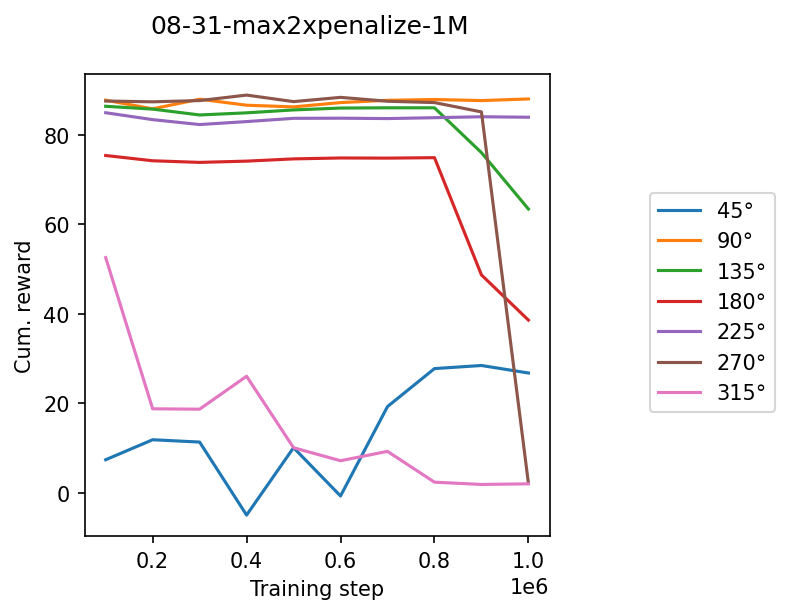

In [65]:
plot_training_evolution('08-31-max2xpenalize-1M', model_folder='08-31-max2xpenalize-delta-2')


# Best reward hyperparams

In [131]:
def get_k_best_hyperparams(k, majority_cols=['clip_range', 'batch_size', 'n_steps', 'n_epochs', 'gamma', 'gae_lambda', 'max_grad_norm'], study_name='sb3-tuning-coktailjet-7-trials'):
    study = optuna.load_study(study_name=study_name, storage='sqlite:///../optuna.db')
    df = study.trials_dataframe(multi_index=True)
    df.sort_values(('value'), inplace=True, ascending=False)
    df = df['params'].head(k)
    print(f'Best hyperparameters (k={k}):')
    for col, col_type in zip(df.columns, df.dtypes):
        if col_type == object or col_type == bool or col_type == str or col in majority_cols:
            print(f'\t{col}:\t{df[col].mode().item()}')
        else:
            print(f'\t{col}:\t{df[col].mean():.2e}±{df[col].std():.2e} (median={df[col].median():.2e})')

## Scenario 1

In [140]:
get_k_best_hyperparams(5, study_name='09-01-reward-tuning-scenario-1-A')
print()
get_k_best_hyperparams(10, study_name='09-01-reward-tuning-scenario-1-A')
print()
get_k_best_hyperparams(20, study_name='09-01-reward-tuning-scenario-1-A')
print()
get_k_best_hyperparams(50, study_name='09-01-reward-tuning-scenario-1-A')

Best hyperparameters (k=5):
	rudder_coef:	4.12e-02±1.83e-02 (median=4.60e-02)
	start_penality:	8.71e-01±6.60e-02 (median=8.71e-01)
	vmc_steepness:	3.46e+00±5.20e-01 (median=3.20e+00)
	xte_steepness:	5.78e+00±1.03e+00 (median=5.48e+00)

Best hyperparameters (k=10):
	rudder_coef:	5.42e-02±3.93e-02 (median=4.87e-02)
	start_penality:	7.93e-01±1.28e-01 (median=8.07e-01)
	vmc_steepness:	4.02e+00±2.19e+00 (median=3.39e+00)
	xte_steepness:	5.81e+00±1.32e+00 (median=5.56e+00)

Best hyperparameters (k=20):
	rudder_coef:	6.57e-02±7.77e-02 (median=4.33e-02)
	start_penality:	7.09e-01±3.02e-01 (median=8.07e-01)
	vmc_steepness:	4.60e+00±3.61e+00 (median=3.26e+00)
	xte_steepness:	5.65e+00±3.81e+00 (median=5.15e+00)

Best hyperparameters (k=50):
	rudder_coef:	7.92e-02±1.14e-01 (median=4.33e-02)
	start_penality:	7.28e-01±2.76e-01 (median=8.07e-01)
	vmc_steepness:	5.15e+00±4.44e+00 (median=3.45e+00)
	xte_steepness:	5.47e+00±3.94e+00 (median=4.82e+00)


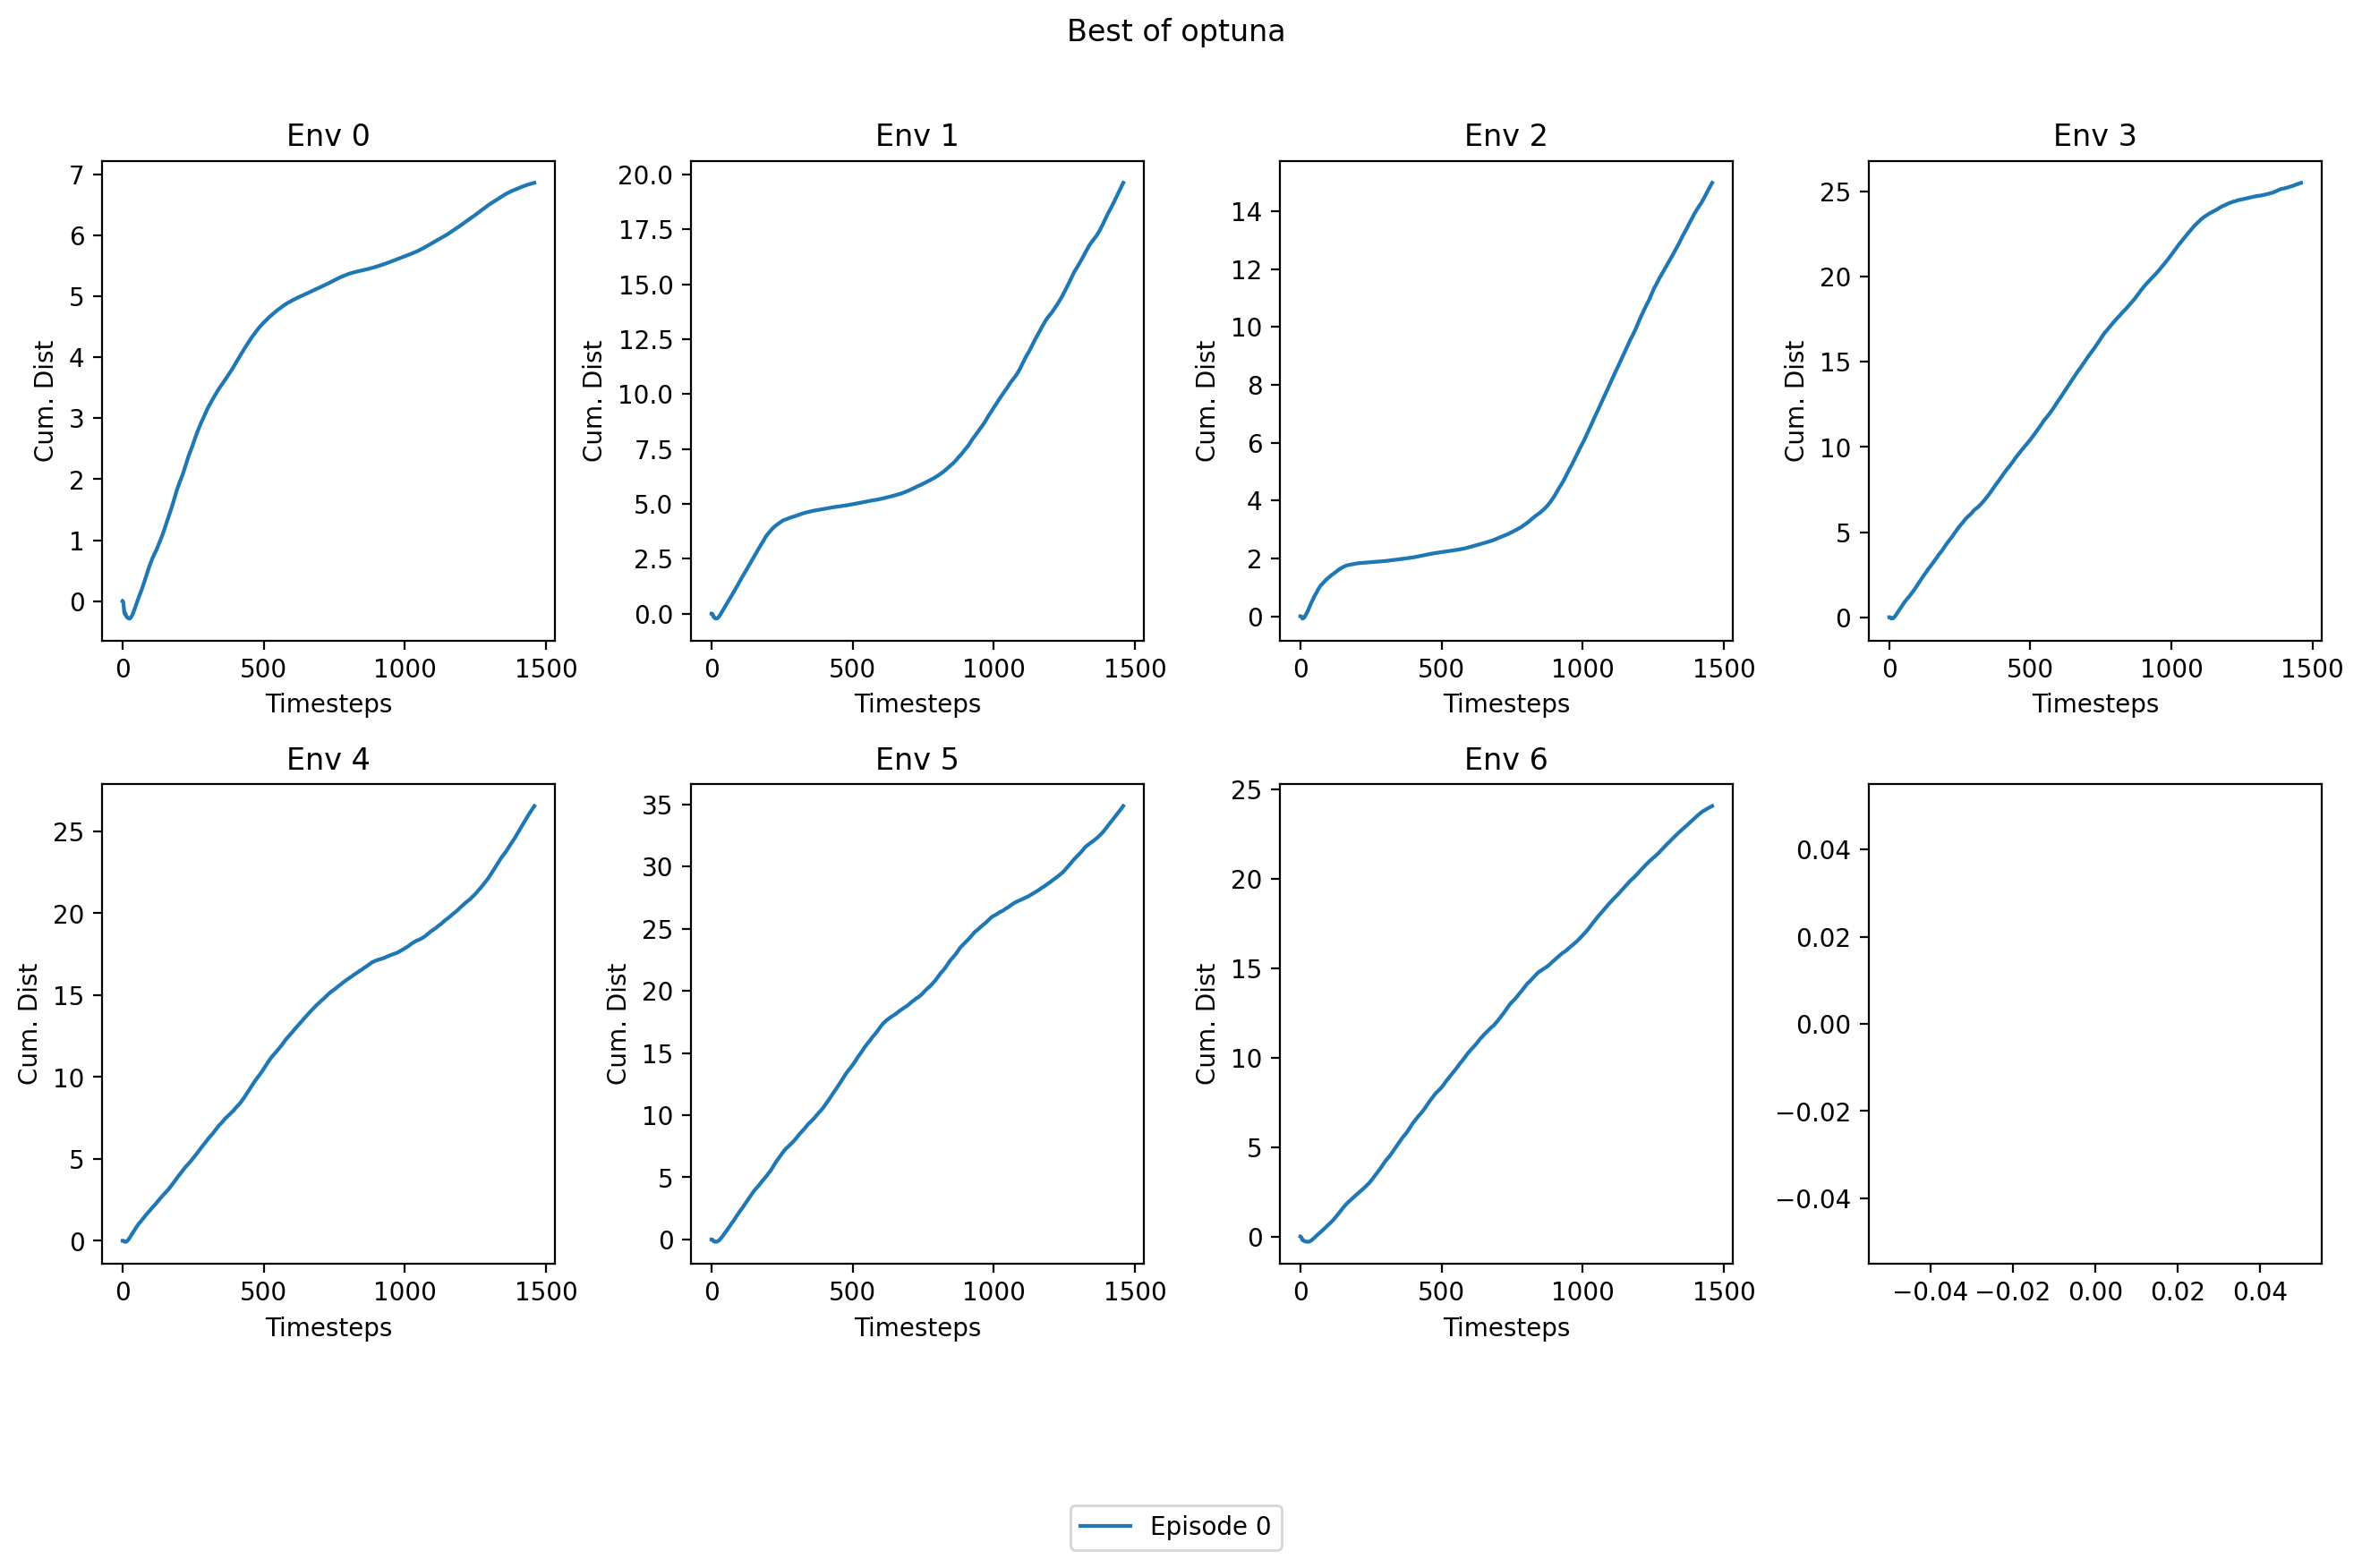

In [135]:
plot_gain_dist_by_episode('09-01-reward-tuning-scenario-1-A-14', train=True, title='Best of optuna');

## Scenario 2

In [141]:
get_k_best_hyperparams(1, study_name='09-01-reward-tuning-scenario-2-A')
print()
get_k_best_hyperparams(5, study_name='09-01-reward-tuning-scenario-2-A')
print()
get_k_best_hyperparams(10, study_name='09-01-reward-tuning-scenario-2-A')
print()
get_k_best_hyperparams(20, study_name='09-01-reward-tuning-scenario-2-A')
print()
get_k_best_hyperparams(50, study_name='09-01-reward-tuning-scenario-2-A')

Best hyperparameters (k=1):
	rudder_coef:	1.06e-01±nan (median=1.06e-01)
	start_penality:	7.01e-01±nan (median=7.01e-01)
	vmc_steepness:	1.02e+00±nan (median=1.02e+00)
	xte_steepness:	4.64e+00±nan (median=4.64e+00)

Best hyperparameters (k=5):
	rudder_coef:	1.19e-01±5.68e-02 (median=1.06e-01)
	start_penality:	6.00e-01±1.20e-01 (median=6.42e-01)
	vmc_steepness:	1.60e+00±7.86e-01 (median=1.49e+00)
	xte_steepness:	5.32e+00±3.60e+00 (median=4.64e+00)

Best hyperparameters (k=10):
	rudder_coef:	1.04e-01±5.03e-02 (median=1.06e-01)
	start_penality:	6.01e-01±1.62e-01 (median=6.45e-01)
	vmc_steepness:	1.99e+00±1.52e+00 (median=1.50e+00)
	xte_steepness:	6.32e+00±3.57e+00 (median=4.72e+00)

Best hyperparameters (k=20):
	rudder_coef:	9.48e-02±5.43e-02 (median=8.74e-02)
	start_penality:	5.32e-01±2.10e-01 (median=5.64e-01)
	vmc_steepness:	2.68e+00±2.37e+00 (median=1.66e+00)
	xte_steepness:	7.28e+00±5.62e+00 (median=4.72e+00)

Best hyperparameters (k=50):
	rudder_coef:	1.91e-01±2.14e-01 (median=1.22e

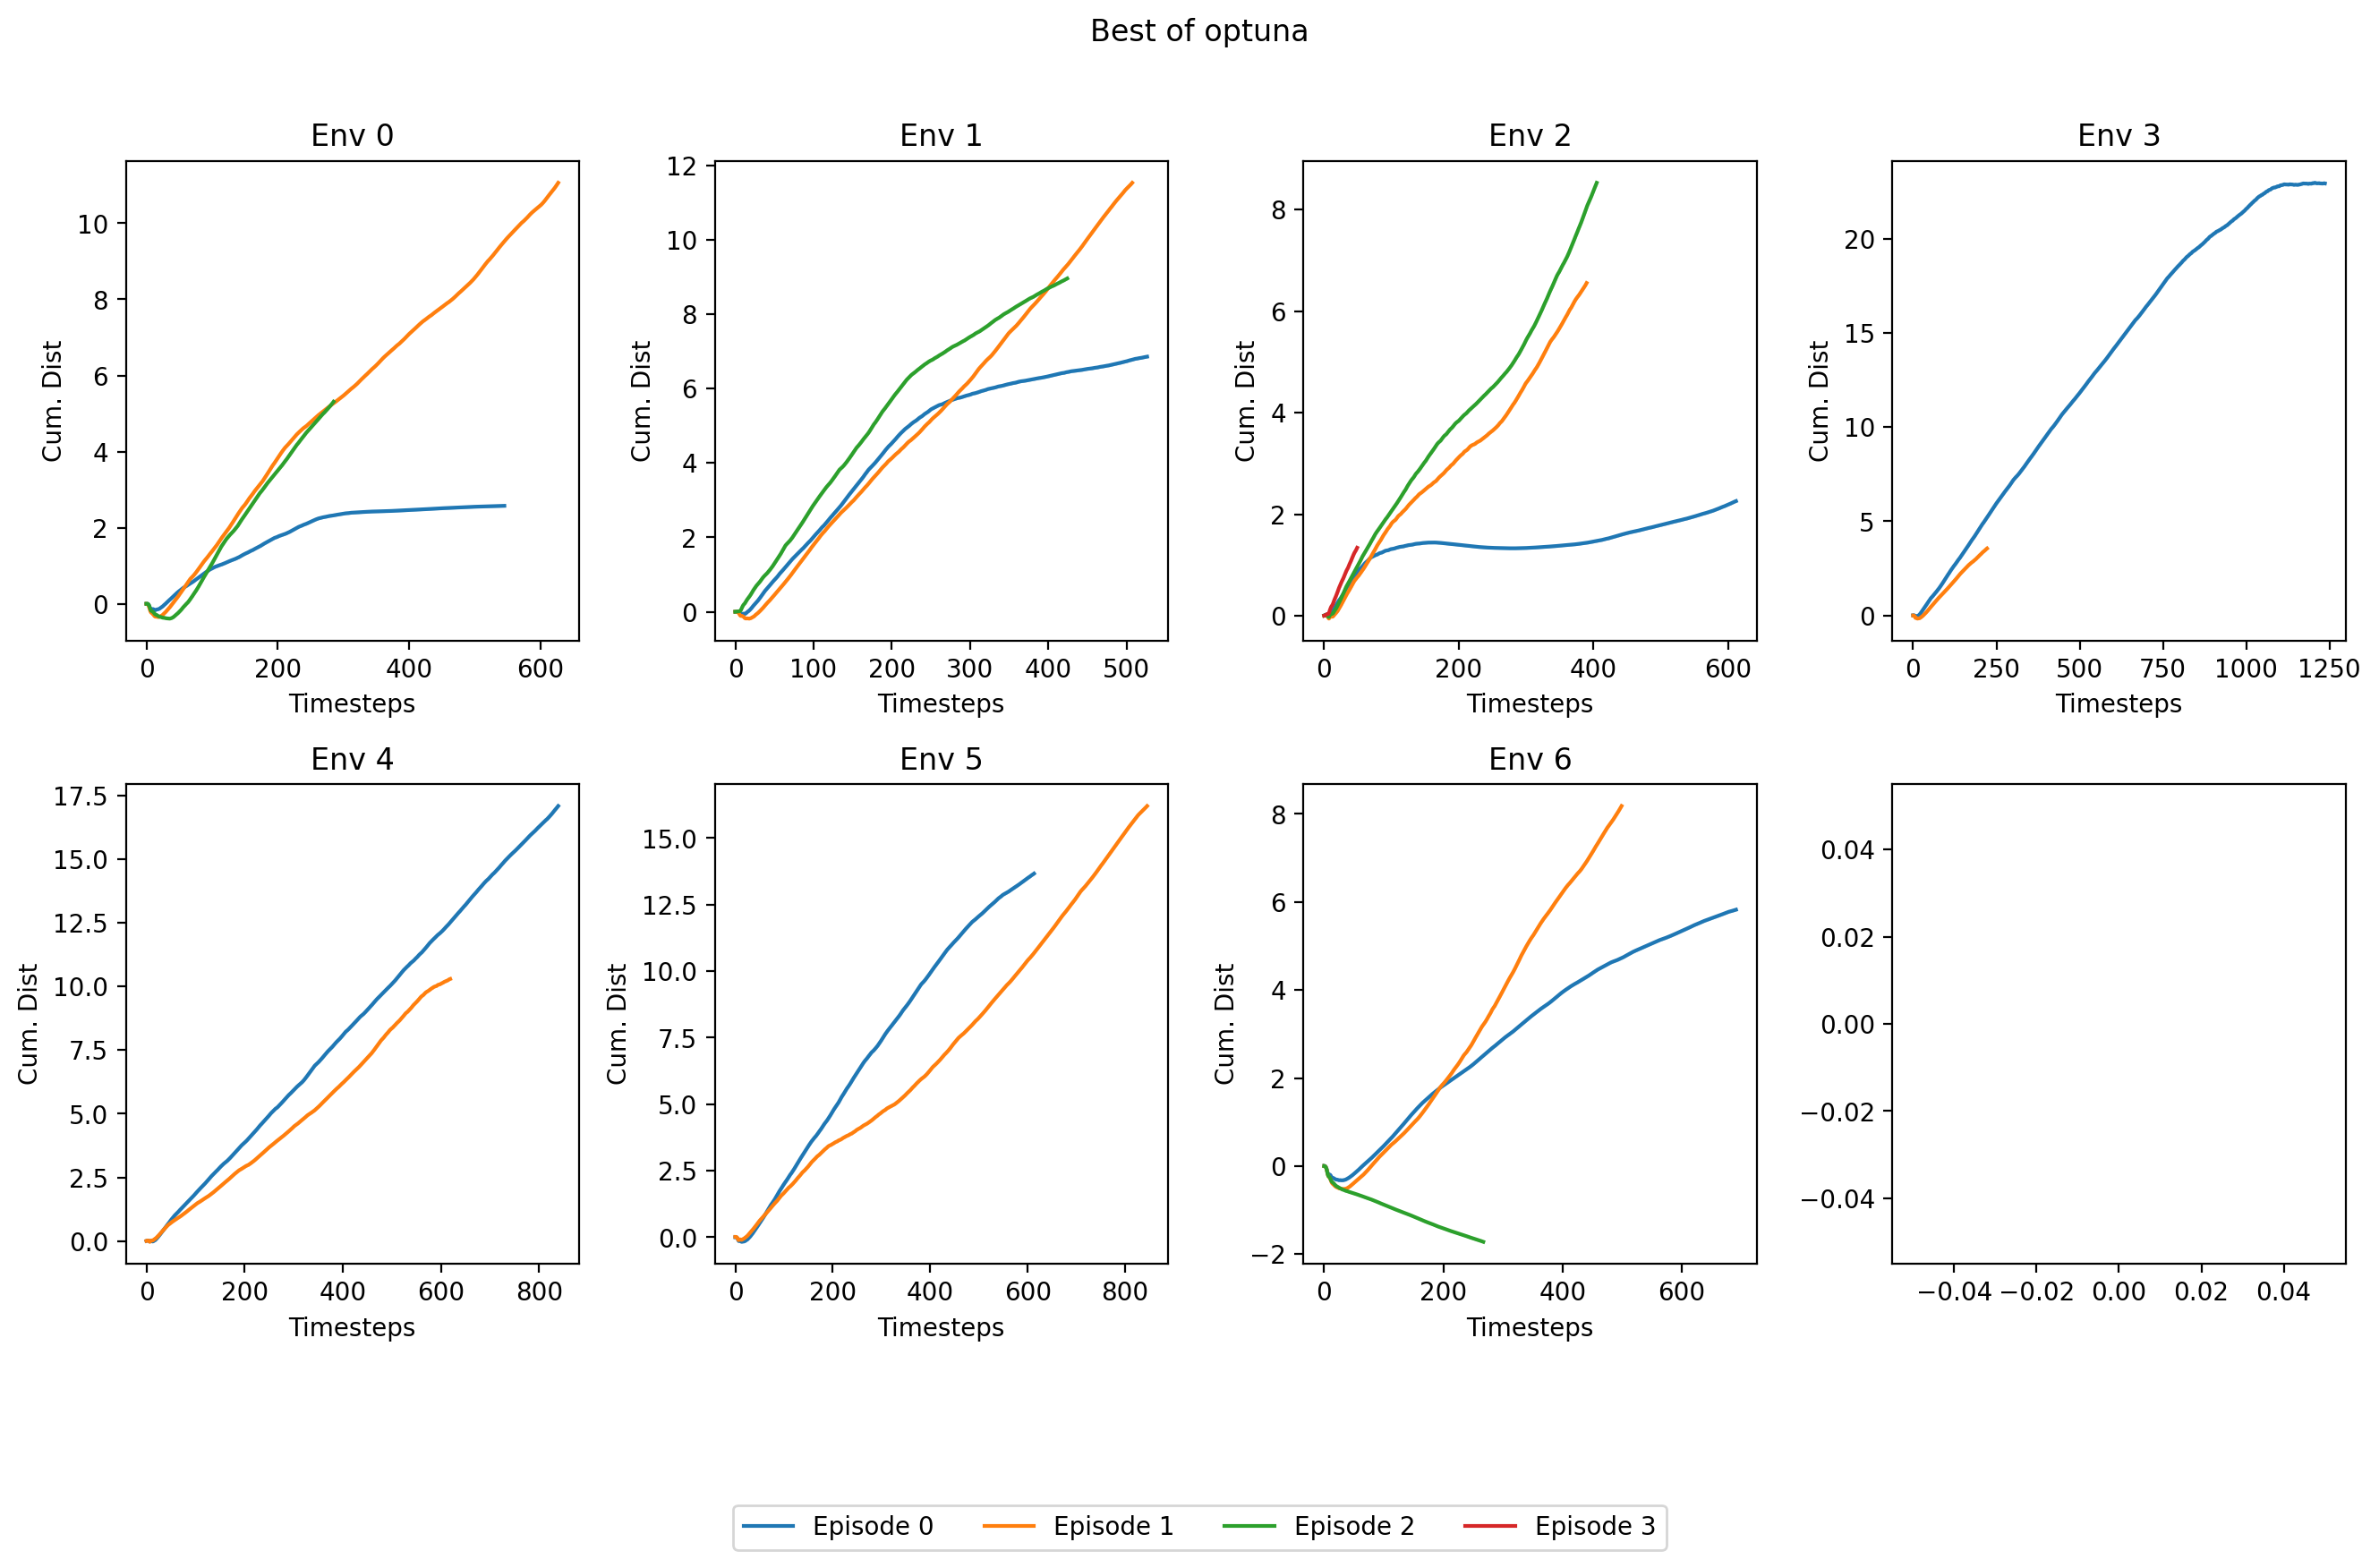

In [139]:
plot_gain_dist_by_episode('09-01-reward-tuning-scenario-2-A-4', train=True, title='Best of optuna');